<a href="https://colab.research.google.com/github/Vaccine-studies/Safety-of-the-Herpes-Zoster-Vaccine-in-the-Older-New-Zealand-Population/blob/main/Copy_of_MoH_R3_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load package

In [ ]:
import pandas as pd
pd.set_option('precision', 4)

pd.options.mode.chained_assignment = None  # default='warn'

import numpy as np

from datetime import date, timedelta

import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from pandas_profiling import ProfileReport

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dir="/content/drive/MyDrive/Fun PhD journey/Endeavour/"

In [ ]:
#missing value/percentage check
def missingvalue(data):
    columns = data.columns
    types=data.dtypes
    percent_missing = data.isnull().sum() * 100 / len(data)
    missing_value_df = pd.DataFrame({'column_name': columns,'column_type':types,'percent_missing': percent_missing})
    missing_value_df=missing_value_df[missing_value_df.percent_missing>0]
    return(missing_value_df.sort_values(by=['percent_missing'],ascending=False))


def dataprofile(df,removemissing=False):
  ##Capitalize column names
  df.columns=df.columns.str.upper()
  to_drop=[]
  temp=[0,0]
  ##create missing value profile
  missingdata=missingvalue(df)
  if removemissing:
    missingcol=missingdata[missingdata.percent_missing>=50].column_name
    df.drop(missingcol,inplace=True,axis=1)
  for i in df.columns:
    if(df[i].dtype=='object'):
      df[i]=df[i].str.strip()
    try:
      ##print missing value >20%
      missingp=missingdata.loc[i,'percent_missing']
      if(missingp>20):
        print(i + " has missing value percentage of" + str(missingp))
    except:
      pass
      ##print single value features
    if(df[i].nunique()==1):
      print(i + " has been dropped due to there is single value in this feature")
      to_drop.append(i)
    elif(df[i].nunique()==df.shape[0]):
      print(i + " may be id as values are totally unique")
    elif(df[i].nunique()==2):
      # df[i]=df[i].astype('bool')
      print(i + " IS A BINARY FEATURE")
    elif(df[i].nunique()==temp[1]):
      print(i + " may be projected correlated with " +str(temp[0]))
    temp=[i,df[i].nunique()]
  print('-----------------------------------------------------------------')
  return df.drop(to_drop,axis=1)


def removeduplicate(df,ids=["EVENT_ID"],top=20):
  df['New']=0
  df['New']=df.groupby(ids).cumcount()+1
  print(df['New'].value_counts().head(20))
  ids.append('New')
  new_df=df.set_index(ids).unstack('New').sort_index(axis=1 , level=1)
  new_df.columns=new_df.columns.map('{0[0]}{0[1]}'.format) 
  new_df=new_df.iloc[:,:top]
  return new_df

def psize(df):
  print(df.shape)

#Load file

In [ ]:
import os
# from pandas_profiling import ProfileReport
folder='MOH-DataServices_Request 2'
folder=dir+folder
df=[]
for file in sorted(os.listdir(folder)):
    if file.endswith(".txt"):
        print(file)
        temp_df=pd.read_csv(os.path.join(folder, file),sep='|')
        df.append(temp_df)
        # prof = ProfileReport(temp_df)
        # prof.to_file(output_file=folder+'/output_' +str(file) +'.html')

MOH-DataServices_cas2207.txt
MOH-DataServices_diags_control_2018.txt
MOH-DataServices_diags_control_2019.txt
MOH-DataServices_diags_control_2020.txt
MOH-DataServices_diags_control_2021.txt
MOH-DataServices_diags_control_lookback_2018.txt
MOH-DataServices_diags_control_lookback_2019.txt
MOH-DataServices_diags_control_lookback_2020.txt
MOH-DataServices_diags_control_lookback_2021.txt
MOH-DataServices_diags_high_risk_2018.txt
MOH-DataServices_diags_high_risk_2019.txt
MOH-DataServices_diags_high_risk_2020.txt
MOH-DataServices_diags_high_risk_2021.txt
MOH-DataServices_diags_hr_lookback_2018.txt
MOH-DataServices_diags_hr_lookback_2019.txt
MOH-DataServices_diags_hr_lookback_2020.txt
MOH-DataServices_diags_hr_lookback_2021.txt
MOH-DataServices_events_control_2018.txt
MOH-DataServices_events_control_2019.txt
MOH-DataServices_events_control_2020.txt
MOH-DataServices_events_control_2021.txt
MOH-DataServices_events_control_lookback_2018.txt
MOH-DataServices_events_control_lookback_2019.txt
MOH-Dat

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
cas,dc18,dc19,dc20,dc21,dclb18,dclb19,dclb20,dclb21,dh18,dh19,dh20,dh21,dhlb18,dhlb19,dhlb20,dhlb21,ec18,ec19,ec20,ec21,eclb18,eclb19,eclb20,eclb21,eh18,eh19,eh20,eh21,ehlb18,ehlb19,ehlb20,ehlb21,mis=df[:]

In [ ]:
pusdig_ctr=pd.concat([dc18,dc19,dc20,dc21])
pusdig_ctrlb=pd.concat([dclb18,dclb19,dclb20,dclb21])
pusdig_hig=pd.concat([dh18,dh19,dh20,dh21])
pusdig_higlb=pd.concat([dhlb18,dhlb19,dhlb20,dhlb21])
puseve_ctr=pd.concat([ec18,ec19,ec20,ec21])
puseve_ctrlb=pd.concat([eclb18,eclb19,eclb20,eclb21])
puseve_hig=pd.concat([eh18,eh19,eh20,eh21])
puseve_higlb=pd.concat([ehlb18,ehlb19,ehlb20,ehlb21])

In [ ]:
#rename specific column names
puseve_ctr.rename(columns = {'DHB_2015':'DHBDOM'}, inplace = True)
puseve_ctrlb.rename(columns = {'DHB_2015':'DHBDOM'}, inplace = True)
puseve_hig.rename(columns = {'DHB_2015':'DHBDOM'}, inplace = True)
puseve_higlb.rename(columns = {'DHB_2015':'DHBDOM'}, inplace = True)

can=dataprofile(cas) 
dem=dataprofile(mis) 
pusdig_ctr=dataprofile(pusdig_ctr)
pusdig_hig=dataprofile(pusdig_hig)
puseve_ctr=dataprofile(puseve_ctr)
puseve_hig=dataprofile(puseve_hig)
pusdig_ctrlb=dataprofile(pusdig_ctrlb)
pusdig_higlb=dataprofile(pusdig_higlb)
puseve_ctrlb=dataprofile(puseve_ctrlb)
puseve_higlb=dataprofile(puseve_higlb)

ENC_NHI may be projected correlated with MASTER_ENC
GENDER IS A BINARY FEATURE
ETHNICG1 may be projected correlated with ETHNICGP
ETHNICG3 has been dropped due to there is single value in this feature
DEP13 may be projected correlated with DEP06
DEP18 may be projected correlated with DEP13
-----------------------------------------------------------------
UNIQUE_ID may be id as values are totally unique
DOD has missing value percentage of94.09810280075943
ETHNIC_CODE_1 may be projected correlated with PRIORITY_ETHNIC_CODE
ETHNIC_CODE_2 has missing value percentage of95.93155392951677
ETHNIC_CODE_2 may be projected correlated with ETHNIC_CODE_1
ETHNIC_CODE_3 has missing value percentage of99.88151166174697
DEP18 may be projected correlated with DEP13
-----------------------------------------------------------------
CLIN_SYS has been dropped due to there is single value in this feature
SUBMITTED_SYSTEM_ID IS A BINARY FEATURE
----------------------------------------------------------------

In [ ]:
##Drop duplicates
dem=dem.drop_duplicates(['MASTER_ENC'])

domcile=pd.read_csv('/content/drive/MyDrive/Fun PhD journey/Endeavour/domicile_code_table_census_v3_2013_0.csv')
morph=pd.read_csv('/content/drive/MyDrive/Fun PhD journey/Endeavour/ICD-10-v8-morph.csv',index_col='ICD')
imd=pd.read_csv('/content/drive/MyDrive/Fun PhD journey/Endeavour/immuneodeficiencies.txt',delimiter='|')

DHB_CODE=['011','021','022','023','031','042','047','051','071','061','081','082','091','092','093','101','111','121','123','160','999','XXX']
DHB_DESCR=["NORTHLAND","WAITEMATA","AUCKLAND","COUNTIES MANUKAU","WAIKATO","LAKES","BAY OF PLENTY","TAIRAWHITI","TARANAKI","HAWKE'S BAY","MIDCENTRAL","WHANGANUI","CAPITAL AND COAST",
           "HUTT","WAIRARAPA","NELSON MARLBOROUGH","WEST COAST","CANTERBURY","SOUTH CANTERBURY","SOUTHERN","OVERSEAS","UNKNOWN"]

DHB_Mapping=pd.DataFrame(list(zip(DHB_CODE, DHB_DESCR)),columns =['DHBDOM', 'LOCATION'])

cat_list=['AGE','GENDER','ETHNICGP','DEP06','DEP13','DEP06_Q','DEP13_Q','LOCATION']

disease_list=['COPD','DIAB','GOUT','CERE','CHRO','ISCH','SERO','PSOE','LUPU','BOWE','PSOR','ANKY','LIVE','CANC','WHOC','APPE','HERN','DIVE','FEMF','CHOC','PAND','SEPS','HAEM','RENC','BURN','LIPO','EPIS']
##list of people who got immuse system problem
imd_list=imd.MASTER_ENCRYPTED_HCU_ID.values
##different cancers list
can_list=[8000,8010,8046,8070,8077,8130,8140,8160,8240,8260,8310,8380,8480,8500,8720,8721,8742,8743,9050,9061,9085,9220,9440,9670,9680,9698,9699,6732,9945,9983]

table_list=['DIAG_YEAR','AGE','GENDER','ETHNICGP_Lvl1','DEP06_Q','DEP13_Q','DEP18_Q','IMD','LOCATION']

#Analyze - Table1

In [ ]:
##Return Primary Diagnose Only?
Type_A_only=True

high risk

In [ ]:
pusdig=pusdig_hig
print('Original pusdig size')
psize(pusdig)
if Type_A_only:
  pusdig=pusdig[pusdig.DIAG_TYP=='A']

print('Type A diagnose pusdig size')
psize(pusdig)

puseve=puseve_hig.drop_duplicates(['MASTER_ENC','EVENT_ID'])

##Get EVENT_ID for different disease
COPD_list=list(pusdig[pusdig.CLIN_CD.str.contains('J40') | pusdig.CLIN_CD.str.contains('J41') | pusdig.CLIN_CD.str.contains('J42') | pusdig.CLIN_CD.str.contains('J43') | pusdig.CLIN_CD.str.contains('J44')].EVENT_ID)
DIAB_list=list(pusdig[pusdig.CLIN_CD.str.contains('E10') | pusdig.CLIN_CD.str.contains('E11') | pusdig.CLIN_CD.str.contains('E12') | pusdig.CLIN_CD.str.contains('E13') | pusdig.CLIN_CD.str.contains('E14')].EVENT_ID)
GOUT_list=list(pusdig[pusdig.CLIN_CD.str.startswith('M10')].EVENT_ID)
CERE_list=list(pusdig[pusdig.CLIN_CD.str.startswith('I6')].EVENT_ID)
CHRO_list=list(pusdig[pusdig.CLIN_CD.str.startswith('N18')].EVENT_ID)
ISCH_list=list(pusdig[pusdig.CLIN_CD.str.contains('I20') | pusdig.CLIN_CD.str.contains('I21') | pusdig.CLIN_CD.str.contains('I22') | pusdig.CLIN_CD.str.contains('I23') | pusdig.CLIN_CD.str.contains('I24')| pusdig.CLIN_CD.str.contains('I25')].EVENT_ID)
SERO_list=list(pusdig[pusdig.CLIN_CD.str.contains('M05') | pusdig.CLIN_CD.str.contains('M06') ].EVENT_ID)
PSOE_list=list(pusdig[pusdig.CLIN_CD.str.startswith('M07')].EVENT_ID)
LUPU_list=list(pusdig[pusdig.CLIN_CD.str.startswith('M32')].EVENT_ID)
BOWE_list=list(pusdig[pusdig.CLIN_CD.str.startswith('K580')].EVENT_ID)
PSOR_list=list(pusdig[pusdig.CLIN_CD.str.startswith('L40')].EVENT_ID)
ANKY_list=list(pusdig[pusdig.CLIN_CD.str.startswith('M450')].EVENT_ID)
LIVE_list=list(pusdig[pusdig.CLIN_CD.str.startswith('K70') | pusdig.CLIN_CD.str.startswith('K72')   | pusdig.CLIN_CD.str.startswith('K73')  | pusdig.CLIN_CD.str.startswith('K74') ].EVENT_ID)

##add AI Disease Flag
AIDI_list=SERO_list+PSOE_list+LUPU_list+BOWE_list+PSOR_list+ANKY_list

STRK_G1_list=list(pusdig[pusdig.CLIN_CD.isin(['I443','I434'])].EVENT_ID)
STRK_G2_list=list(pusdig[pusdig.CLIN_CD.isin(['I435','G458','G459','G460','G461','G462','G463','G464','G465','G466','G467','G468'])].EVENT_ID)
STRK_G3_list=list(pusdig[pusdig.CLIN_CD.isin(['I436','I437'])].EVENT_ID)
STRK_G4_list=list(pusdig[pusdig.CLIN_CD.str.startswith('I60') 
| pusdig.CLIN_CD.str.startswith('I61') | pusdig.CLIN_CD.str.startswith('I62') | pusdig.CLIN_CD.str.startswith('I63') | pusdig.CLIN_CD.str.startswith('I64')
 | pusdig.CLIN_CD.str.startswith('I65') | pusdig.CLIN_CD.str.startswith('I66') | pusdig.CLIN_CD.str.startswith('I67')].EVENT_ID)
STRK_list=STRK_G1_list+STRK_G2_list+STRK_G3_list+STRK_G4_list

#Acute myocardial infarction
CARD_G1_list=list(pusdig[pusdig.CLIN_CD.isin(['I410','I411','I210','I211','I212','I213','I214','I215','I216','I217','I218','I219','I418'])].EVENT_ID)
#Acute pericarditis
CARD_G2_list=list(pusdig[pusdig.CLIN_CD.isin(['I420','I308','I309'])].EVENT_ID)
#Acute myocarditis
CARD_G3_list=list(pusdig[pusdig.CLIN_CD.isin(['I409','I408','I514','I401','I402','I403','I404','I405','I406','I407'
,'I412','I413','I414','I415','I416','I417','I419','I421','I422'])].EVENT_ID)

CARD_G4_list=list(pusdig[pusdig.CLIN_CD.isin(['I429','I428','I430','I516','I517','I518','I519','I255','I256'])].EVENT_ID)
CARD_G5_list=list(pusdig[pusdig.CLIN_CD.isin(['I500','I501','I509'])].EVENT_ID)
CARD_list=CARD_G1_list+CARD_G2_list+CARD_G3_list+CARD_G4_list+CARD_G5_list

MENI_list=list(pusdig[pusdig.CLIN_CD.isin(['A870','A89','G020','G028','G030','G038','G052','G0331','G039','G04','G05','G934','G312','G92'])].EVENT_ID)
RAMS_list=list(pusdig[pusdig.CLIN_CD.isin(['B022','G510','H490','H491','H492','H493','H494','H510','G511','G519'])].EVENT_ID)

MEDI_G1_list=list(pusdig[pusdig.CLIN_CD.isin(['L0312','L038','L039','M7961','M7962','M7963','M7964','M7968',
                                              'M7969','M7989','T801','T802','T888','I889','I890','I891','L049','R599'])].EVENT_ID)
MEDI_G2_list=list(pusdig[pusdig.CLIN_CD.isin(['T783','T887','T784','L500','L501','L508','L509','T749','T782','T805',
                                              'L0310','L508','R223','R229','L024','L028','L029','L042','L043','L048','L049','L299'])].EVENT_ID)
MEDI_list=MEDI_G1_list+MEDI_G2_list

##add sensitivity disease
WHOC_list=list(pusdig[pusdig.CLIN_CD.isin(['A370','A371','A378','A379'])].EVENT_ID)

APPE_list=list(pusdig[pusdig.CLIN_CD.isin(['K350','K351','K359','K36','K37','K380','K381','K382','K383','K388','K389'])].EVENT_ID)

HERN_list=list(pusdig[pusdig.CLIN_CD.isin(['K4000','K4001','K4010','K4011','K4020','K4021','K4030','K4031','K4040','K4041','K4090','K4091','K410','K411','K412','K413','K414',
'K419','K420','K421','K429','K430','K431','K439','K440','K441','K449','K450','K451','K458','K460','K461','K469'])].EVENT_ID)

DIVE_list=list(pusdig[pusdig.CLIN_CD.isin(['K5700','K5701','K5702','K5703','K5710','K5711','K5712','K513','K5720','K5721','K5722','K5723','K5730','K5731',
'K5732','K5733','K5740','K5741','K5742','K5743','K5780','K5781, K5782, K5783','K5790','K57921','K5792','K5793'])].EVENT_ID)

FEMF_list=list(pusdig[pusdig.CLIN_CD.isin(['S7200','S7201','S7202','S7203','S7204','S7205','S7208','S7210','S7211','S722','S723','S7240','S7241','S7242','S7243','S7244','S727','S728','S729'])].EVENT_ID)

CHOC_list=list(pusdig[pusdig.CLIN_CD.isin(['K8000','K8001','K8010','K8011','K8020','K8021','K8030','K8031','K8040','K8041','K8050','K8051','K8080','K8081','K810',
                                           'K811','K818','K819','K820','K821','K822','K823','K824','K828','K829','K830','K831','K832','K833','K834','K835','K835','K838','K839','K870'])].EVENT_ID)
PAND_list=list(pusdig[pusdig.CLIN_CD.isin(['K85','K860','K861','K862','K863','K868','K869','K871','K903'])].EVENT_ID)
SEPS_list=list(pusdig[pusdig.CLIN_CD.isin(pusdig.CLIN_CD.str.startswith('A40') | pusdig.CLIN_CD.str.startswith('A41'))].EVENT_ID)
HAEM_list=list(pusdig[pusdig.CLIN_CD.isin(['O224','O872']) | pusdig.CLIN_CD.str.startswith('I84')].EVENT_ID)
RENC_list=list(pusdig[pusdig.CLIN_CD.isin(pusdig.CLIN_CD.str.startswith('N20') | pusdig.CLIN_CD.str.startswith('N21') | pusdig.CLIN_CD.str.startswith('N22') | pusdig.CLIN_CD.str.startswith('N23'))].EVENT_ID)
BURN_list=list(pusdig[pusdig.CLIN_CD.isin(pusdig.CLIN_CD.str.startswith('M6137') | pusdig.CLIN_CD.str.startswith('M6138') | pusdig.CLIN_CD.str.startswith('M6139') | pusdig.CLIN_CD.str.startswith('T2')  | pusdig.CLIN_CD.str.startswith('T3'))].EVENT_ID)
LIPO_list=list(pusdig[pusdig.CLIN_CD.isin(pusdig.CLIN_CD.str.startswith('D17'))].EVENT_ID)
EPIS_list=list(pusdig[pusdig.CLIN_CD.isin(['R040'])].EVENT_ID)
CANC_list=list(can.MASTER_ENC.unique())

##Create Level1 Ethnicity group
puseve['ETHNICGP_Lvl1']=puseve['ETHNICGP']//10

puseve["COPD"] = np.where(puseve["EVENT_ID"].isin(COPD_list),1, 0)
puseve["DIAB"] = np.where(puseve["EVENT_ID"].isin(DIAB_list),1, 0)
puseve["GOUT"] = np.where(puseve["EVENT_ID"].isin(GOUT_list),1, 0)
puseve["CERE"] = np.where(puseve["EVENT_ID"].isin(CERE_list),1, 0)
puseve["CHRO"] = np.where(puseve["EVENT_ID"].isin(CHRO_list),1, 0)
puseve["ISCH"] = np.where(puseve["EVENT_ID"].isin(ISCH_list),1, 0)
puseve["SERO"] = np.where(puseve["EVENT_ID"].isin(SERO_list),1, 0)
puseve["PSOE"] = np.where(puseve["EVENT_ID"].isin(PSOE_list),1, 0)
puseve["LUPU"] = np.where(puseve["EVENT_ID"].isin(LUPU_list),1, 0)
puseve["BOWE"] = np.where(puseve["EVENT_ID"].isin(BOWE_list),1, 0)
puseve["PSOR"] = np.where(puseve["EVENT_ID"].isin(PSOR_list),1, 0)
puseve["ANKY"] = np.where(puseve["EVENT_ID"].isin(ANKY_list),1, 0)
puseve["LIVE"] = np.where(puseve["EVENT_ID"].isin(LIVE_list),1, 0)
puseve["AIDI"] = np.where(puseve["EVENT_ID"].isin(AIDI_list),1, 0)
puseve["CANC"] = np.where(puseve["EVENT_ID"].isin(CANC_list),1, 0)

print("Add disease flag for puseve patients")
psize(puseve)

puseve["STRK"] = np.where(puseve["EVENT_ID"].isin(STRK_list),1, 0)
puseve["STRK_G1"] = np.where(puseve["EVENT_ID"].isin(STRK_G1_list),1, 0)
puseve["STRK_G2"] = np.where(puseve["EVENT_ID"].isin(STRK_G2_list),1, 0)
puseve["STRK_G3"] = np.where(puseve["EVENT_ID"].isin(STRK_G3_list),1, 0)
puseve["STRK_G4"] = np.where(puseve["EVENT_ID"].isin(STRK_G4_list),1, 0)

puseve["CARD"] = np.where(puseve["EVENT_ID"].isin(CARD_list),1, 0)
puseve["CARD_G1"] = np.where(puseve["EVENT_ID"].isin(CARD_G1_list),1, 0)
puseve["CARD_G2"] = np.where(puseve["EVENT_ID"].isin(CARD_G2_list),1, 0)
puseve["CARD_G3"] = np.where(puseve["EVENT_ID"].isin(CARD_G3_list),1, 0)
puseve["CARD_G4"] = np.where(puseve["EVENT_ID"].isin(CARD_G4_list),1, 0)
puseve["CARD_G5"] = np.where(puseve["EVENT_ID"].isin(CARD_G5_list),1, 0)

puseve["MENI"] = np.where(puseve["EVENT_ID"].isin(MENI_list),1, 0)
puseve["RAMS"] = np.where(puseve["EVENT_ID"].isin(RAMS_list),1, 0)
puseve["MEDI"] = np.where(puseve["EVENT_ID"].isin(MEDI_list),1, 0)
puseve["MEDI_G1"] = np.where(puseve["EVENT_ID"].isin(MEDI_G1_list),1, 0)
puseve["MEDI_G2"] = np.where(puseve["EVENT_ID"].isin(MEDI_G2_list),1, 0)

puseve["WHOC"] = np.where(puseve["EVENT_ID"].isin(WHOC_list),1, 0)
puseve["APPE"] = np.where(puseve["EVENT_ID"].isin(APPE_list),1, 0)
puseve["HERN"] = np.where(puseve["EVENT_ID"].isin(HERN_list),1, 0)
puseve["DIVE"] = np.where(puseve["EVENT_ID"].isin(DIVE_list),1, 0)
puseve["FEMF"] = np.where(puseve["EVENT_ID"].isin(FEMF_list),1, 0)
puseve["CHOC"] = np.where(puseve["EVENT_ID"].isin(CHOC_list),1, 0)
puseve["PAND"] = np.where(puseve["EVENT_ID"].isin(PAND_list),1, 0)
puseve["SEPS"] = np.where(puseve["EVENT_ID"].isin(SEPS_list),1, 0)
puseve["HAEM"] = np.where(puseve["EVENT_ID"].isin(HAEM_list),1, 0)
puseve["RENC"] = np.where(puseve["EVENT_ID"].isin(RENC_list),1, 0)
puseve["BURN"] = np.where(puseve["EVENT_ID"].isin(BURN_list),1, 0)
puseve["LIPO"] = np.where(puseve["EVENT_ID"].isin(LIPO_list),1, 0)
puseve["EPIS"] = np.where(puseve["EVENT_ID"].isin(EPIS_list),1, 0)


print("Add high risk disease flag for puseve patients")
psize(puseve)

##add DEP Quin
puseve['DEP06_Q']=5
puseve.loc[(puseve.DEP06==2) | (puseve.DEP06==1),"DEP06_Q"]=1
puseve.loc[(puseve.DEP06==4) | (puseve.DEP06==3),"DEP06_Q"]=2
puseve.loc[(puseve.DEP06==6) | (puseve.DEP06==5),"DEP06_Q"]=3
puseve.loc[(puseve.DEP06==8) | (puseve.DEP06==7),"DEP06_Q"]=4
puseve['DEP13_Q']=5
puseve.loc[(puseve.DEP13==2) | (puseve.DEP13==1),"DEP13_Q"]=1
puseve.loc[(puseve.DEP13==4) | (puseve.DEP13==3),"DEP13_Q"]=2
puseve.loc[(puseve.DEP13==6) | (puseve.DEP13==5),"DEP13_Q"]=3
puseve.loc[(puseve.DEP13==8) | (puseve.DEP13==7),"DEP13_Q"]=4

puseve['DEP18_Q']=5
puseve.loc[(puseve.DEP18==2) | (puseve.DEP18==1),"DEP18_Q"]=1
puseve.loc[(puseve.DEP18==4) | (puseve.DEP18==3),"DEP18_Q"]=2
puseve.loc[(puseve.DEP18==6) | (puseve.DEP18==5),"DEP18_Q"]=3
puseve.loc[(puseve.DEP18==8) | (puseve.DEP18==7),"DEP18_Q"]=4

##add DHB Location
puseve.DHBDOM=puseve.DHBDOM.astype(str).str.zfill(3)
puseve=puseve.merge(DHB_Mapping,how="left",on="DHBDOM")

puseve["IMD"] = np.where(puseve["MASTER_ENC"].isin(imd_list),1, 0)

print("Add other category flag for puseve patients")
psize(puseve)


##add cancer type in the puseve dataset
for i in can_list:
  temp_list=list(can[can.MORPH==i].drop_duplicates(keep='first',subset=['MASTER_ENC']).MASTER_ENC)
  puseve[i] = np.where(puseve["MASTER_ENC"].isin(temp_list),1, 0)

print("Add cancer/which type of cancer flag for puseve patients")
psize(puseve)


puseve.loc[:,'EVSTDATE'] = pd.to_datetime(puseve['EVSTDATE'],dayfirst=True)
puseve.loc[:,'VACCINATION_DATE'] = pd.to_datetime(puseve['VACCINATION_DATE'],dayfirst=True)
puseve.loc[:,'DIAG_YEAR']=puseve['EVSTDATE'].dt.year

##Create person days
puseve['Person_Days']=puseve['EVSTDATE']-puseve['VACCINATION_DATE']
puseve['Person_Days']=puseve.Person_Days.dt.days

# puseve.loc[:,'AGE']=pd.cut(puseve['AGE_DIS'], [-1,0,9,19,29,39,49,59,64,69,74,79,150], labels=['1<','1-9','10-19','20-29','30-39','40-49','50-59','60-64','65-69','70-74','75-79','>=80'])
puseve.loc[:,'AGE']=pd.cut(puseve['AGE_DIS'], [-1,54,59,64,69,74,79,150], labels=['50-54','55-59','60-64','65-69','70-74','75-79','>=80'])
puseve_hig_processed=puseve.copy()

Original pusdig size
(6348, 5)
Type A diagnose pusdig size
(685, 5)
Add disease flag for puseve patients
(685, 48)
Add high risk disease flag for puseve patients
(685, 77)
Add other category flag for puseve patients
(685, 82)
Add cancer/which type of cancer flag for puseve patients
(685, 112)


control

In [ ]:
pusdig=pusdig_ctr
print('Original pusdig size')
psize(pusdig)
if Type_A_only:
  pusdig=pusdig[pusdig.DIAG_TYP=='A']

print('Type A diagnose pusdig size')
psize(pusdig)

puseve=puseve_ctr.drop_duplicates(['MASTER_ENC','EVENT_ID'])

##Get EVENT_ID for different disease
COPD_list=list(pusdig[pusdig.CLIN_CD.str.contains('J40') | pusdig.CLIN_CD.str.contains('J41') | pusdig.CLIN_CD.str.contains('J42') | pusdig.CLIN_CD.str.contains('J43') | pusdig.CLIN_CD.str.contains('J44')].EVENT_ID)
DIAB_list=list(pusdig[pusdig.CLIN_CD.str.contains('E10') | pusdig.CLIN_CD.str.contains('E11') | pusdig.CLIN_CD.str.contains('E12') | pusdig.CLIN_CD.str.contains('E13') | pusdig.CLIN_CD.str.contains('E14')].EVENT_ID)
GOUT_list=list(pusdig[pusdig.CLIN_CD.str.startswith('M10')].EVENT_ID)
CERE_list=list(pusdig[pusdig.CLIN_CD.str.startswith('I6')].EVENT_ID)
CHRO_list=list(pusdig[pusdig.CLIN_CD.str.startswith('N18')].EVENT_ID)
ISCH_list=list(pusdig[pusdig.CLIN_CD.str.contains('I20') | pusdig.CLIN_CD.str.contains('I21') | pusdig.CLIN_CD.str.contains('I22') | pusdig.CLIN_CD.str.contains('I23') | pusdig.CLIN_CD.str.contains('I24')| pusdig.CLIN_CD.str.contains('I25')].EVENT_ID)
SERO_list=list(pusdig[pusdig.CLIN_CD.str.contains('M05') | pusdig.CLIN_CD.str.contains('M06') ].EVENT_ID)
PSOE_list=list(pusdig[pusdig.CLIN_CD.str.startswith('M07')].EVENT_ID)
LUPU_list=list(pusdig[pusdig.CLIN_CD.str.startswith('M32')].EVENT_ID)
BOWE_list=list(pusdig[pusdig.CLIN_CD.str.startswith('K580')].EVENT_ID)
PSOR_list=list(pusdig[pusdig.CLIN_CD.str.startswith('L40')].EVENT_ID)
ANKY_list=list(pusdig[pusdig.CLIN_CD.str.startswith('M450')].EVENT_ID)
LIVE_list=list(pusdig[pusdig.CLIN_CD.str.startswith('K70') | pusdig.CLIN_CD.str.startswith('K72')   | pusdig.CLIN_CD.str.startswith('K73')  | pusdig.CLIN_CD.str.startswith('K74') ].EVENT_ID)

##add AI Disease Flag
AIDI_list=SERO_list+PSOE_list+LUPU_list+BOWE_list+PSOR_list+ANKY_list

STRK_G1_list=list(pusdig[pusdig.CLIN_CD.isin(['I443','I434'])].EVENT_ID)
STRK_G2_list=list(pusdig[pusdig.CLIN_CD.isin(['I435','G458','G459','G460','G461','G462','G463','G464','G465','G466','G467','G468'])].EVENT_ID)
STRK_G3_list=list(pusdig[pusdig.CLIN_CD.isin(['I436','I437'])].EVENT_ID)
STRK_G4_list=list(pusdig[pusdig.CLIN_CD.str.startswith('I60') 
| pusdig.CLIN_CD.str.startswith('I61') | pusdig.CLIN_CD.str.startswith('I62') | pusdig.CLIN_CD.str.startswith('I63') | pusdig.CLIN_CD.str.startswith('I64')
 | pusdig.CLIN_CD.str.startswith('I65') | pusdig.CLIN_CD.str.startswith('I66') | pusdig.CLIN_CD.str.startswith('I67')].EVENT_ID)
STRK_list=STRK_G1_list+STRK_G2_list+STRK_G3_list+STRK_G4_list

#Acute myocardial infarction
CARD_G1_list=list(pusdig[pusdig.CLIN_CD.isin(['I410','I411','I210','I211','I212','I213','I214','I215','I216','I217','I218','I219','I418'])].EVENT_ID)
#Acute pericarditis
CARD_G2_list=list(pusdig[pusdig.CLIN_CD.isin(['I420','I308','I309'])].EVENT_ID)
#Acute myocarditis
CARD_G3_list=list(pusdig[pusdig.CLIN_CD.isin(['I409','I408','I514','I401','I402','I403','I404','I405','I406','I407'
,'I412','I413','I414','I415','I416','I417','I419','I421','I422'])].EVENT_ID)

CARD_G4_list=list(pusdig[pusdig.CLIN_CD.isin(['I429','I428','I430','I516','I517','I518','I519','I255','I256'])].EVENT_ID)
CARD_G5_list=list(pusdig[pusdig.CLIN_CD.isin(['I500','I501','I509'])].EVENT_ID)
CARD_list=CARD_G1_list+CARD_G2_list+CARD_G3_list+CARD_G4_list+CARD_G5_list

MENI_list=list(pusdig[pusdig.CLIN_CD.isin(['A870','A89','G020','G028','G030','G038','G052','G0331','G039','G04','G05','G934','G312','G92'])].EVENT_ID)
RAMS_list=list(pusdig[pusdig.CLIN_CD.isin(['B022','G510','H490','H491','H492','H493','H494','H510','G511','G519'])].EVENT_ID)

MEDI_G1_list=list(pusdig[pusdig.CLIN_CD.isin(['L0312','L038','L039','M7961','M7962','M7963','M7964','M7968',
                                              'M7969','M7989','T801','T802','T888','I889','I890','I891','L049','R599'])].EVENT_ID)
MEDI_G2_list=list(pusdig[pusdig.CLIN_CD.isin(['T783','T887','T784','L500','L501','L508','L509','T749','T782','T805',
                                              'L0310','L508','R223','R229','L024','L028','L029','L042','L043','L048','L049','L299'])].EVENT_ID)
MEDI_list=MEDI_G1_list+MEDI_G2_list

##add sensitivity disease
WHOC_list=list(pusdig[pusdig.CLIN_CD.isin(['A370','A371','A378','A379'])].EVENT_ID)

APPE_list=list(pusdig[pusdig.CLIN_CD.isin(['K350','K351','K359','K36','K37','K380','K381','K382','K383','K388','K389'])].EVENT_ID)

HERN_list=list(pusdig[pusdig.CLIN_CD.isin(['K4000','K4001','K4010','K4011','K4020','K4021','K4030','K4031','K4040','K4041','K4090','K4091','K410','K411','K412','K413','K414',
'K419','K420','K421','K429','K430','K431','K439','K440','K441','K449','K450','K451','K458','K460','K461','K469'])].EVENT_ID)

DIVE_list=list(pusdig[pusdig.CLIN_CD.isin(['K5700','K5701','K5702','K5703','K5710','K5711','K5712','K513','K5720','K5721','K5722','K5723','K5730','K5731',
'K5732','K5733','K5740','K5741','K5742','K5743','K5780','K5781, K5782, K5783','K5790','K57921','K5792','K5793'])].EVENT_ID)

FEMF_list=list(pusdig[pusdig.CLIN_CD.isin(['S7200','S7201','S7202','S7203','S7204','S7205','S7208','S7210','S7211','S722','S723','S7240','S7241','S7242','S7243','S7244','S727','S728','S729'])].EVENT_ID)

CHOC_list=list(pusdig[pusdig.CLIN_CD.isin(['K8000','K8001','K8010','K8011','K8020','K8021','K8030','K8031','K8040','K8041','K8050','K8051','K8080','K8081','K810',
                                           'K811','K818','K819','K820','K821','K822','K823','K824','K828','K829','K830','K831','K832','K833','K834','K835','K835','K838','K839','K870'])].EVENT_ID)
PAND_list=list(pusdig[pusdig.CLIN_CD.isin(['K85','K860','K861','K862','K863','K868','K869','K871','K903'])].EVENT_ID)
SEPS_list=list(pusdig[pusdig.CLIN_CD.isin(pusdig.CLIN_CD.str.startswith('A40') | pusdig.CLIN_CD.str.startswith('A41'))].EVENT_ID)
HAEM_list=list(pusdig[pusdig.CLIN_CD.isin(['O224','O872']) | pusdig.CLIN_CD.str.startswith('I84')].EVENT_ID)
RENC_list=list(pusdig[pusdig.CLIN_CD.isin(pusdig.CLIN_CD.str.startswith('N20') | pusdig.CLIN_CD.str.startswith('N21') | pusdig.CLIN_CD.str.startswith('N22') | pusdig.CLIN_CD.str.startswith('N23'))].EVENT_ID)
BURN_list=list(pusdig[pusdig.CLIN_CD.isin(pusdig.CLIN_CD.str.startswith('M6137') | pusdig.CLIN_CD.str.startswith('M6138') | pusdig.CLIN_CD.str.startswith('M6139') | pusdig.CLIN_CD.str.startswith('T2')  | pusdig.CLIN_CD.str.startswith('T3'))].EVENT_ID)
LIPO_list=list(pusdig[pusdig.CLIN_CD.isin(pusdig.CLIN_CD.str.startswith('D17'))].EVENT_ID)
EPIS_list=list(pusdig[pusdig.CLIN_CD.isin(['R040'])].EVENT_ID)
CANC_list=list(can.MASTER_ENC.unique())

##Create Level1 Ethnicity group
puseve['ETHNICGP_Lvl1']=puseve['ETHNICGP']//10

puseve["COPD"] = np.where(puseve["EVENT_ID"].isin(COPD_list),1, 0)
puseve["DIAB"] = np.where(puseve["EVENT_ID"].isin(DIAB_list),1, 0)
puseve["GOUT"] = np.where(puseve["EVENT_ID"].isin(GOUT_list),1, 0)
puseve["CERE"] = np.where(puseve["EVENT_ID"].isin(CERE_list),1, 0)
puseve["CHRO"] = np.where(puseve["EVENT_ID"].isin(CHRO_list),1, 0)
puseve["ISCH"] = np.where(puseve["EVENT_ID"].isin(ISCH_list),1, 0)
puseve["SERO"] = np.where(puseve["EVENT_ID"].isin(SERO_list),1, 0)
puseve["PSOE"] = np.where(puseve["EVENT_ID"].isin(PSOE_list),1, 0)
puseve["LUPU"] = np.where(puseve["EVENT_ID"].isin(LUPU_list),1, 0)
puseve["BOWE"] = np.where(puseve["EVENT_ID"].isin(BOWE_list),1, 0)
puseve["PSOR"] = np.where(puseve["EVENT_ID"].isin(PSOR_list),1, 0)
puseve["ANKY"] = np.where(puseve["EVENT_ID"].isin(ANKY_list),1, 0)
puseve["LIVE"] = np.where(puseve["EVENT_ID"].isin(LIVE_list),1, 0)
puseve["AIDI"] = np.where(puseve["EVENT_ID"].isin(AIDI_list),1, 0)
puseve["CANC"] = np.where(puseve["EVENT_ID"].isin(CANC_list),1, 0)

print("Add disease flag for puseve patients")
psize(puseve)

puseve["STRK"] = np.where(puseve["EVENT_ID"].isin(STRK_list),1, 0)
puseve["STRK_G1"] = np.where(puseve["EVENT_ID"].isin(STRK_G1_list),1, 0)
puseve["STRK_G2"] = np.where(puseve["EVENT_ID"].isin(STRK_G2_list),1, 0)
puseve["STRK_G3"] = np.where(puseve["EVENT_ID"].isin(STRK_G3_list),1, 0)
puseve["STRK_G4"] = np.where(puseve["EVENT_ID"].isin(STRK_G4_list),1, 0)

puseve["CARD"] = np.where(puseve["EVENT_ID"].isin(CARD_list),1, 0)
puseve["CARD_G1"] = np.where(puseve["EVENT_ID"].isin(CARD_G1_list),1, 0)
puseve["CARD_G2"] = np.where(puseve["EVENT_ID"].isin(CARD_G2_list),1, 0)
puseve["CARD_G3"] = np.where(puseve["EVENT_ID"].isin(CARD_G3_list),1, 0)
puseve["CARD_G4"] = np.where(puseve["EVENT_ID"].isin(CARD_G4_list),1, 0)
puseve["CARD_G5"] = np.where(puseve["EVENT_ID"].isin(CARD_G5_list),1, 0)

puseve["MENI"] = np.where(puseve["EVENT_ID"].isin(MENI_list),1, 0)
puseve["RAMS"] = np.where(puseve["EVENT_ID"].isin(RAMS_list),1, 0)
puseve["MEDI"] = np.where(puseve["EVENT_ID"].isin(MEDI_list),1, 0)
puseve["MEDI_G1"] = np.where(puseve["EVENT_ID"].isin(MEDI_G1_list),1, 0)
puseve["MEDI_G2"] = np.where(puseve["EVENT_ID"].isin(MEDI_G2_list),1, 0)

puseve["WHOC"] = np.where(puseve["EVENT_ID"].isin(WHOC_list),1, 0)
puseve["APPE"] = np.where(puseve["EVENT_ID"].isin(APPE_list),1, 0)
puseve["HERN"] = np.where(puseve["EVENT_ID"].isin(HERN_list),1, 0)
puseve["DIVE"] = np.where(puseve["EVENT_ID"].isin(DIVE_list),1, 0)
puseve["FEMF"] = np.where(puseve["EVENT_ID"].isin(FEMF_list),1, 0)
puseve["CHOC"] = np.where(puseve["EVENT_ID"].isin(CHOC_list),1, 0)
puseve["PAND"] = np.where(puseve["EVENT_ID"].isin(PAND_list),1, 0)
puseve["SEPS"] = np.where(puseve["EVENT_ID"].isin(SEPS_list),1, 0)
puseve["HAEM"] = np.where(puseve["EVENT_ID"].isin(HAEM_list),1, 0)
puseve["RENC"] = np.where(puseve["EVENT_ID"].isin(RENC_list),1, 0)
puseve["BURN"] = np.where(puseve["EVENT_ID"].isin(BURN_list),1, 0)
puseve["LIPO"] = np.where(puseve["EVENT_ID"].isin(LIPO_list),1, 0)
puseve["EPIS"] = np.where(puseve["EVENT_ID"].isin(EPIS_list),1, 0)


print("Add high risk disease flag for puseve patients")
psize(puseve)

##add DEP Quin
puseve['DEP06_Q']=5
puseve.loc[(puseve.DEP06==2) | (puseve.DEP06==1),"DEP06_Q"]=1
puseve.loc[(puseve.DEP06==4) | (puseve.DEP06==3),"DEP06_Q"]=2
puseve.loc[(puseve.DEP06==6) | (puseve.DEP06==5),"DEP06_Q"]=3
puseve.loc[(puseve.DEP06==8) | (puseve.DEP06==7),"DEP06_Q"]=4
puseve['DEP13_Q']=5
puseve.loc[(puseve.DEP13==2) | (puseve.DEP13==1),"DEP13_Q"]=1
puseve.loc[(puseve.DEP13==4) | (puseve.DEP13==3),"DEP13_Q"]=2
puseve.loc[(puseve.DEP13==6) | (puseve.DEP13==5),"DEP13_Q"]=3
puseve.loc[(puseve.DEP13==8) | (puseve.DEP13==7),"DEP13_Q"]=4

puseve['DEP18_Q']=5
puseve.loc[(puseve.DEP18==2) | (puseve.DEP18==1),"DEP18_Q"]=1
puseve.loc[(puseve.DEP18==4) | (puseve.DEP18==3),"DEP18_Q"]=2
puseve.loc[(puseve.DEP18==6) | (puseve.DEP18==5),"DEP18_Q"]=3
puseve.loc[(puseve.DEP18==8) | (puseve.DEP18==7),"DEP18_Q"]=4

##add DHB Location
puseve.DHBDOM=puseve.DHBDOM.astype(str).str.zfill(3)
puseve=puseve.merge(DHB_Mapping,how="left",on="DHBDOM")

puseve["IMD"] = np.where(puseve["MASTER_ENC"].isin(imd_list),1, 0)

print("Add other category flag for puseve patients")
psize(puseve)


##add cancer type in the puseve dataset
for i in can_list:
  temp_list=list(can[can.MORPH==i].drop_duplicates(keep='first',subset=['MASTER_ENC']).MASTER_ENC)
  puseve[i] = np.where(puseve["MASTER_ENC"].isin(temp_list),1, 0)

print("Add cancer/which type of cancer flag for puseve patients")
psize(puseve)


puseve.loc[:,'EVSTDATE'] = pd.to_datetime(puseve['EVSTDATE'],dayfirst=True)
puseve.loc[:,'VACCINATION_DATE'] = pd.to_datetime(puseve['VACCINATION_DATE'],dayfirst=True)
puseve.loc[:,'DIAG_YEAR']=puseve['EVSTDATE'].dt.year

##Create person days
puseve['Person_Days']=puseve['EVSTDATE']-puseve['VACCINATION_DATE']
puseve['Person_Days']=puseve.Person_Days.dt.days

# puseve.loc[:,'AGE']=pd.cut(puseve['AGE_DIS'], [-1,0,9,19,29,39,49,59,64,69,74,79,150], labels=['1<','1-9','10-19','20-29','30-39','40-49','50-59','60-64','65-69','70-74','75-79','>=80'])
puseve.loc[:,'AGE']=pd.cut(puseve['AGE_DIS'], [-1,54,59,64,69,74,79,150], labels=['50-54','55-59','60-64','65-69','70-74','75-79','>=80'])
puseve_ctr_processed=puseve.copy()

Original pusdig size
(18467, 5)
Type A diagnose pusdig size
(1868, 5)
Add disease flag for puseve patients
(1868, 48)
Add high risk disease flag for puseve patients
(1868, 77)
Add other category flag for puseve patients
(1868, 82)
Add cancer/which type of cancer flag for puseve patients
(1868, 112)


##Table1

In [ ]:
puseve_hig_processed['FLAG']=1
puseve_ctr_processed['FLAG']=0
puseve_full=pd.concat([puseve_hig_processed,puseve_ctr_processed],axis=0)

data=puseve_full.copy()

In [ ]:
data.MASTER_ENC.nunique()

1975

In [ ]:
pyramid=data.groupby(['AGE','GENDER'])['AGE_DIS'].agg(['count']).reset_index()
pyramid['count']=np.where(pyramid.GENDER=='M',pyramid['count']*-1,pyramid['count'])

df=pyramid.copy()
# Draw Plot
plt.figure(figsize=(10,6), dpi= 80)
group_col = 'GENDER'
order_of_bars = df.AGE.unique()[::-1]
colors = [plt.cm.Spectral(i/float(len(df[group_col].unique())-1)) for i in range(len(df[group_col].unique()))]

for c, group in zip(colors, df[group_col].unique()):
    sns.barplot(x='count', y='AGE', data=df.loc[df[group_col]==group, :], order=order_of_bars, color=c, label=group)

# Decorations
plt.xlabel("$cases$")
plt.ylabel("AGE of cases")
xticks = plt.gca().get_xticks().astype(np.int)
plt.xticks(xticks, labels=np.abs(xticks));
plt.yticks(fontsize=12)
plt.title("Population Pyramid of the cases", fontsize=22)
plt.legend()
plt.savefig('pyramid.pdf',dpi=500)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


#Table for events level

In [ ]:
for i in table_list+disease_list:
  display(data.pivot_table(index=[i],columns='FLAG',values='MASTER_ENC',aggfunc=np.count_nonzero,margins=True))
  display(data.pivot_table(index=[i],columns='FLAG',values='MASTER_ENC',aggfunc=np.count_nonzero,margins=True).transform(lambda x: x*200/x.sum()))

FLAG,0,1,All
DIAG_YEAR,,,
2018,1152,468,1620
2019,418,138,556
2020,191,53,244
2021,107,26,133
All,1868,685,2553


FLAG,0,1,All
DIAG_YEAR,,,
2018,61.670236,68.321168,63.454759
2019,22.376874,20.145985,21.778300
2020,10.224839,7.737226,9.557383
2021,5.728051,3.795620,5.209557
All,100.000000,100.000000,100.000000


FLAG,0,1,All
AGE,,,
50-54,NaN,1.000000,1
55-59,1.000000,1.000000,2
60-64,3.000000,5.000000,8
65-69,422.000000,163.000000,585
70-74,560.000000,214.000000,774
75-79,671.000000,238.000000,909
>=80,211.000000,63.000000,274
All,1868.000000,685.000000,2553


FLAG,0,1,All
AGE,,,
50-54,NaN,0.145985,0.039170
55-59,0.053533,0.145985,0.078339
60-64,0.160600,0.729927,0.313357
65-69,22.591006,23.795620,22.914219
70-74,29.978587,31.240876,30.317274
75-79,35.920771,34.744526,35.605170
>=80,11.295503,9.197080,10.732472
All,100.000000,100.000000,100.000000


FLAG,0,1,All
GENDER,,,
F,790,312,1102
M,1078,373,1451
All,1868,685,2553


FLAG,0,1,All
GENDER,,,
F,42.291221,45.547445,43.164904
M,57.708779,54.452555,56.835096
All,100.000000,100.000000,100.000000


FLAG,0,1,All
ETHNICGP_Lvl1,,,
1,1338,471,1809
2,268,110,378
3,123,51,174
4,111,44,155
5,22,7,29
9,6,2,8
All,1868,685,2553


FLAG,0,1,All
ETHNICGP_Lvl1,,,
1,71.627409,68.759124,70.857814
2,14.346895,16.058394,14.806110
3,6.584582,7.445255,6.815511
4,5.942184,6.423358,6.071289
5,1.177730,1.021898,1.135919
9,0.321199,0.291971,0.313357
All,100.000000,100.000000,100.000000


FLAG,0,1,All
DEP06_Q,,,
1,298,95,393
2,308,97,405
3,322,137,459
4,477,184,661
5,463,172,635
All,1868,685,2553


FLAG,0,1,All
DEP06_Q,,,
1,15.952891,13.868613,15.393655
2,16.488223,14.160584,15.863690
3,17.237687,20.000000,17.978848
4,25.535332,26.861314,25.891108
5,24.785867,25.109489,24.872699
All,100.000000,100.000000,100.000000


FLAG,0,1,All
DEP13_Q,,,
1,271,94,365
2,305,89,394
3,330,149,479
4,438,156,594
5,524,197,721
All,1868,685,2553


FLAG,0,1,All
DEP13_Q,,,
1,14.507495,13.722628,14.296906
2,16.327623,12.992701,15.432824
3,17.665953,21.751825,18.762241
4,23.447537,22.773723,23.266745
5,28.051392,28.759124,28.241285
All,100.000000,100.000000,100.000000


FLAG,0,1,All
DEP18_Q,,,
1,251,86,337
2,332,109,441
3,353,138,491
4,435,163,598
5,497,189,686
All,1868,685,2553


FLAG,0,1,All
DEP18_Q,,,
1,13.436831,12.554745,13.200157
2,17.773019,15.912409,17.273796
3,18.897216,20.145985,19.232276
4,23.286938,23.795620,23.423423
5,26.605996,27.591241,26.870349
All,100.000000,100.000000,100.000000


FLAG,0,1,All
IMD,,,
0,1682,625,2307
1,186,60,246
All,1868,685,2553


FLAG,0,1,All
IMD,,,
0,90.042827,91.240876,90.364277
1,9.957173,8.759124,9.635723
All,100.000000,100.000000,100.000000


FLAG,0,1,All
LOCATION,,,
AUCKLAND,141,66,207
BAY OF PLENTY,95,31,126
CANTERBURY,215,85,300
CAPITAL AND COAST,80,30,110
COUNTIES MANUKAU,205,84,289
HAWKE'S BAY,53,20,73
HUTT,75,22,97
LAKES,57,18,75
MIDCENTRAL,89,37,126


FLAG,0,1,All
LOCATION,,,
AUCKLAND,7.548180,9.635036,8.108108
BAY OF PLENTY,5.085653,4.525547,4.935370
CANTERBURY,11.509636,12.408759,11.750881
CAPITAL AND COAST,4.282655,4.379562,4.308656
COUNTIES MANUKAU,10.974304,12.262774,11.320016
HAWKE'S BAY,2.837259,2.919708,2.859381
HUTT,4.014989,3.211679,3.799452
LAKES,3.051392,2.627737,2.937720
MIDCENTRAL,4.764454,5.401460,4.935370


FLAG,0,1,All
COPD,,,
0,1682,616,2298
1,186,69,255
All,1868,685,2553


FLAG,0,1,All
COPD,,,
0,90.042827,89.927007,90.011751
1,9.957173,10.072993,9.988249
All,100.000000,100.000000,100.000000


FLAG,0,1,All
DIAB,,,
0,1221,467,1688
1,647,218,865
All,1868,685,2553


FLAG,0,1,All
DIAB,,,
0,65.364026,68.175182,66.118292
1,34.635974,31.824818,33.881708
All,100.000000,100.000000,100.000000


FLAG,0,1,All
GOUT,,,
0,1844,678,2522
1,24,7,31
All,1868,685,2553


FLAG,0,1,All
GOUT,,,
0,98.715203,98.978102,98.785742
1,1.284797,1.021898,1.214258
All,100.000000,100.000000,100.000000


FLAG,0,1,All
CERE,,,
0,1262,477,1739
1,606,208,814
All,1868,685,2553


FLAG,0,1,All
CERE,,,
0,67.558887,69.635036,68.115942
1,32.441113,30.364964,31.884058
All,100.000000,100.000000,100.000000


FLAG,0,1,All
CHRO,,,
0,1573,573,2146
1,295,112,407
All,1868,685,2553


FLAG,0,1,All
CHRO,,,
0,84.207709,83.649635,84.057971
1,15.792291,16.350365,15.942029
All,100.000000,100.000000,100.000000


FLAG,0,1,All
ISCH,,,
0,1611,593,2204
1,257,92,349
All,1868,685,2553


FLAG,0,1,All
ISCH,,,
0,86.241970,86.569343,86.329808
1,13.758030,13.430657,13.670192
All,100.000000,100.000000,100.000000


FLAG,0,1,All
SERO,,,
0,1866,684,2550
1,2,1,3
All,1868,685,2553


FLAG,0,1,All
SERO,,,
0,99.892934,99.854015,99.882491
1,0.107066,0.145985,0.117509
All,100.000000,100.000000,100.000000


FLAG,0,1,All
PSOE,,,
0,1868,685,2553
All,1868,685,2553


FLAG,0,1,All
PSOE,,,
0,100.000000,100.000000,100.000000
All,100.000000,100.000000,100.000000


FLAG,0,1,All
LUPU,,,
0,1868,685,2553
All,1868,685,2553


FLAG,0,1,All
LUPU,,,
0,100.000000,100.000000,100.000000
All,100.000000,100.000000,100.000000


FLAG,0,1,All
BOWE,,,
0,1868,685,2553
All,1868,685,2553


FLAG,0,1,All
BOWE,,,
0,100.000000,100.000000,100.000000
All,100.000000,100.000000,100.000000


FLAG,0,1,All
PSOR,,,
0,1866,684,2550
1,2,1,3
All,1868,685,2553


FLAG,0,1,All
PSOR,,,
0,99.892934,99.854015,99.882491
1,0.107066,0.145985,0.117509
All,100.000000,100.000000,100.000000


FLAG,0,1,All
ANKY,,,
0,1868,685,2553
All,1868,685,2553


FLAG,0,1,All
ANKY,,,
0,100.000000,100.000000,100.000000
All,100.000000,100.000000,100.000000


FLAG,0,1,All
LIVE,,,
0,1845,677,2522
1,23,8,31
All,1868,685,2553


FLAG,0,1,All
LIVE,,,
0,98.768737,98.832117,98.785742
1,1.231263,1.167883,1.214258
All,100.000000,100.000000,100.000000


FLAG,0,1,All
CANC,,,
0,1868,685,2553
All,1868,685,2553


FLAG,0,1,All
CANC,,,
0,100.000000,100.000000,100.000000
All,100.000000,100.000000,100.000000


FLAG,0,1,All
WHOC,,,
0,1868,685,2553
All,1868,685,2553


FLAG,0,1,All
WHOC,,,
0,100.000000,100.000000,100.000000
All,100.000000,100.000000,100.000000


FLAG,0,1,All
APPE,,,
0,1867,684,2551
1,1,1,2
All,1868,685,2553


FLAG,0,1,All
APPE,,,
0,99.946467,99.854015,99.921661
1,0.053533,0.145985,0.078339
All,100.000000,100.000000,100.000000


FLAG,0,1,All
HERN,,,
0,1867,683,2550
1,1,2,3
All,1868,685,2553


FLAG,0,1,All
HERN,,,
0,99.946467,99.708029,99.882491
1,0.053533,0.291971,0.117509
All,100.000000,100.000000,100.000000


FLAG,0,1,All
DIVE,,,
0,1863,682,2545
1,5,3,8
All,1868,685,2553


FLAG,0,1,All
DIVE,,,
0,99.732334,99.562044,99.686643
1,0.267666,0.437956,0.313357
All,100.000000,100.000000,100.000000


FLAG,0,1,All
FEMF,,,
0,1846,676,2522
1,22,9,31
All,1868,685,2553


FLAG,0,1,All
FEMF,,,
0,98.822270,98.686131,98.785742
1,1.177730,1.313869,1.214258
All,100.000000,100.000000,100.000000


FLAG,0,1,All
CHOC,,,
0,1854,678,2532
1,14,7,21
All,1868,685,2553


FLAG,0,1,All
CHOC,,,
0,99.250535,98.978102,99.177438
1,0.749465,1.021898,0.822562
All,100.000000,100.000000,100.000000


FLAG,0,1,All
PAND,,,
0,1865,682,2547
1,3,3,6
All,1868,685,2553


FLAG,0,1,All
PAND,,,
0,99.839400,99.562044,99.764982
1,0.160600,0.437956,0.235018
All,100.000000,100.000000,100.000000


FLAG,0,1,All
SEPS,,,
0,1868,685,2553
All,1868,685,2553


FLAG,0,1,All
SEPS,,,
0,100.000000,100.000000,100.000000
All,100.000000,100.000000,100.000000


FLAG,0,1,All
HAEM,,,
0,1857,684,2541
1,11,1,12
All,1868,685,2553


FLAG,0,1,All
HAEM,,,
0,99.411135,99.854015,99.529965
1,0.588865,0.145985,0.470035
All,100.000000,100.000000,100.000000


FLAG,0,1,All
RENC,,,
0,1868,685,2553
All,1868,685,2553


FLAG,0,1,All
RENC,,,
0,100.000000,100.000000,100.000000
All,100.000000,100.000000,100.000000


FLAG,0,1,All
BURN,,,
0,1868,685,2553
All,1868,685,2553


FLAG,0,1,All
BURN,,,
0,100.000000,100.000000,100.000000
All,100.000000,100.000000,100.000000


FLAG,0,1,All
LIPO,,,
0,1868,685,2553
All,1868,685,2553


FLAG,0,1,All
LIPO,,,
0,100.000000,100.000000,100.000000
All,100.000000,100.000000,100.000000


FLAG,0,1,All
EPIS,,,
0,1856,681,2537
1,12,4,16
All,1868,685,2553


FLAG,0,1,All
EPIS,,,
0,99.357602,99.416058,99.373286
1,0.642398,0.583942,0.626714
All,100.000000,100.000000,100.000000


#Table for individual level

In [ ]:
data.shape

(2553, 116)

In [ ]:
data1a=data.copy()
data1a['ADVERSE_FLAG']=data1a['STRK']+data1a['CARD']+data1a['MENI']+data1a['RAMS']+data1a['MEDI']
data1a=data1a[data1a.ADVERSE_FLAG>0]
data1a.shape

(1431, 117)

In [ ]:
data1a=data.groupby(['MASTER_ENC']).max().reset_index()

In [ ]:
for i in table_list+disease_list:
  display(data1a.pivot_table(index=[i],columns='FLAG',values='MASTER_ENC',aggfunc=np.count_nonzero,margins=True))
  display(data1a.pivot_table(index=[i],columns='FLAG',values='MASTER_ENC',aggfunc=np.count_nonzero,margins=True).transform(lambda x: x*200/x.sum()))

FLAG,0,1,All
DIAG_YEAR,,,
2018,497,240,737
2019,179,78,257
2020,94,35,129
2021,57,17,74
All,827,370,1197


FLAG,0,1,All
DIAG_YEAR,,,
2018,60.0967,64.8649,61.5706
2019,21.6445,21.0811,21.4703
2020,11.3664,9.4595,10.7769
2021,6.8924,4.5946,6.1821
All,100.0000,100.0000,100.0000


FLAG,0,1,All
AGE,,,
55-59,1.0,NaN,1
60-64,1.0,2.0,3
65-69,199.0,89.0,288
70-74,239.0,117.0,356
75-79,293.0,132.0,425
>=80,94.0,30.0,124
All,827.0,370.0,1197


FLAG,0,1,All
AGE,,,
55-59,0.1209,NaN,0.0835
60-64,0.1209,0.5405,0.2506
65-69,24.0629,24.0541,24.0602
70-74,28.8996,31.6216,29.7410
75-79,35.4293,35.6757,35.5054
>=80,11.3664,8.1081,10.3592
All,100.0000,100.0000,100.0000


FLAG,0,1,All
GENDER,,,
F,332,159,491
M,495,211,706
All,827,370,1197


FLAG,0,1,All
GENDER,,,
F,40.1451,42.973,41.0192
M,59.8549,57.027,58.9808
All,100.0000,100.000,100.0000


FLAG,0,1,All
ETHNICGP_Lvl1,,,
1,607,254,861
2,105,62,167
3,49,21,70
4,57,27,84
5,6,4,10
9,3,2,5
All,827,370,1197


FLAG,0,1,All
ETHNICGP_Lvl1,,,
1,73.3978,68.6486,71.9298
2,12.6965,16.7568,13.9515
3,5.9250,5.6757,5.8480
4,6.8924,7.2973,7.0175
5,0.7255,1.0811,0.8354
9,0.3628,0.5405,0.4177
All,100.0000,100.0000,100.0000


FLAG,0,1,All
DEP06_Q,,,
1,132,49,181
2,152,55,207
3,148,79,227
4,205,99,304
5,190,88,278
All,827,370,1197


FLAG,0,1,All
DEP06_Q,,,
1,15.9613,13.2432,15.1211
2,18.3797,14.8649,17.2932
3,17.8960,21.3514,18.9641
4,24.7884,26.7568,25.3968
5,22.9746,23.7838,23.2247
All,100.0000,100.0000,100.0000


FLAG,0,1,All
DEP13_Q,,,
1,130,52,182
2,136,50,186
3,156,81,237
4,188,86,274
5,217,101,318
All,827,370,1197


FLAG,0,1,All
DEP13_Q,,,
1,15.7195,14.0541,15.2047
2,16.4450,13.5135,15.5388
3,18.8634,21.8919,19.7995
4,22.7328,23.2432,22.8906
5,26.2394,27.2973,26.5664
All,100.0000,100.0000,100.0000


FLAG,0,1,All
DEP18_Q,,,
1,123,49,172
2,149,59,208
3,168,80,248
4,185,84,269
5,202,98,300
All,827,370,1197


FLAG,0,1,All
DEP18_Q,,,
1,14.8730,13.2432,14.3693
2,18.0169,15.9459,17.3768
3,20.3144,21.6216,20.7185
4,22.3700,22.7027,22.4728
5,24.4256,26.4865,25.0627
All,100.0000,100.0000,100.0000


FLAG,0,1,All
IMD,,,
0,759,337,1096
1,68,33,101
All,827,370,1197


FLAG,0,1,All
IMD,,,
0,91.7775,91.0811,91.5622
1,8.2225,8.9189,8.4378
All,100.0000,100.0000,100.0000


FLAG,0,1,All
LOCATION,,,
AUCKLAND,60,30,90
BAY OF PLENTY,45,17,62
CANTERBURY,96,47,143
CAPITAL AND COAST,38,16,54
COUNTIES MANUKAU,82,46,128
HAWKE'S BAY,28,10,38
HUTT,32,14,46
LAKES,24,8,32
MIDCENTRAL,41,22,63


FLAG,0,1,All
LOCATION,,,
AUCKLAND,7.2551,8.1081,7.5188
BAY OF PLENTY,5.4414,4.5946,5.1796
CANTERBURY,11.6082,12.7027,11.9465
CAPITAL AND COAST,4.5949,4.3243,4.5113
COUNTIES MANUKAU,9.9154,12.4324,10.6934
HAWKE'S BAY,3.3857,2.7027,3.1746
HUTT,3.8694,3.7838,3.8429
LAKES,2.9021,2.1622,2.6734
MIDCENTRAL,4.9577,5.9459,5.2632


FLAG,0,1,All
COPD,,,
0,822,366,1188
1,5,4,9
All,827,370,1197


FLAG,0,1,All
COPD,,,
0,99.3954,98.9189,99.2481
1,0.6046,1.0811,0.7519
All,100.0000,100.0000,100.0000


FLAG,0,1,All
DIAB,,,
0,827.0,368.0,1195
1,NaN,2.0,2
All,827.0,370.0,1197


FLAG,0,1,All
DIAB,,,
0,100.0,99.4595,99.8329
1,NaN,0.5405,0.1671
All,100.0,100.0000,100.0000


FLAG,0,1,All
GOUT,,,
0,827,370,1197
All,827,370,1197


FLAG,0,1,All
GOUT,,,
0,100.0,100.0,100.0
All,100.0,100.0,100.0


FLAG,0,1,All
CERE,,,
0,471,235,706
1,356,135,491
All,827,370,1197


FLAG,0,1,All
CERE,,,
0,56.9528,63.5135,58.9808
1,43.0472,36.4865,41.0192
All,100.0000,100.0000,100.0000


FLAG,0,1,All
CHRO,,,
0,827.0,369.0,1196
1,NaN,1.0,1
All,827.0,370.0,1197


FLAG,0,1,All
CHRO,,,
0,100.0,99.7297,99.9165
1,NaN,0.2703,0.0835
All,100.0,100.0000,100.0000


FLAG,0,1,All
ISCH,,,
0,754,342,1096
1,73,28,101
All,827,370,1197


FLAG,0,1,All
ISCH,,,
0,91.1729,92.4324,91.5622
1,8.8271,7.5676,8.4378
All,100.0000,100.0000,100.0000


FLAG,0,1,All
SERO,,,
0,827,370,1197
All,827,370,1197


FLAG,0,1,All
SERO,,,
0,100.0,100.0,100.0
All,100.0,100.0,100.0


FLAG,0,1,All
PSOE,,,
0,827,370,1197
All,827,370,1197


FLAG,0,1,All
PSOE,,,
0,100.0,100.0,100.0
All,100.0,100.0,100.0


FLAG,0,1,All
LUPU,,,
0,827,370,1197
All,827,370,1197


FLAG,0,1,All
LUPU,,,
0,100.0,100.0,100.0
All,100.0,100.0,100.0


FLAG,0,1,All
BOWE,,,
0,827,370,1197
All,827,370,1197


FLAG,0,1,All
BOWE,,,
0,100.0,100.0,100.0
All,100.0,100.0,100.0


FLAG,0,1,All
PSOR,,,
0,827,370,1197
All,827,370,1197


FLAG,0,1,All
PSOR,,,
0,100.0,100.0,100.0
All,100.0,100.0,100.0


FLAG,0,1,All
ANKY,,,
0,827,370,1197
All,827,370,1197


FLAG,0,1,All
ANKY,,,
0,100.0,100.0,100.0
All,100.0,100.0,100.0


FLAG,0,1,All
LIVE,,,
0,827,370,1197
All,827,370,1197


FLAG,0,1,All
LIVE,,,
0,100.0,100.0,100.0
All,100.0,100.0,100.0


FLAG,0,1,All
CANC,,,
0,827,370,1197
All,827,370,1197


FLAG,0,1,All
CANC,,,
0,100.0,100.0,100.0
All,100.0,100.0,100.0


FLAG,0,1,All
WHOC,,,
0,827,370,1197
All,827,370,1197


FLAG,0,1,All
WHOC,,,
0,100.0,100.0,100.0
All,100.0,100.0,100.0


FLAG,0,1,All
APPE,,,
0,827,370,1197
All,827,370,1197


FLAG,0,1,All
APPE,,,
0,100.0,100.0,100.0
All,100.0,100.0,100.0


FLAG,0,1,All
HERN,,,
0,827,370,1197
All,827,370,1197


FLAG,0,1,All
HERN,,,
0,100.0,100.0,100.0
All,100.0,100.0,100.0


FLAG,0,1,All
DIVE,,,
0,826.0,370.0,1196
1,1.0,NaN,1
All,827.0,370.0,1197


FLAG,0,1,All
DIVE,,,
0,99.8791,100.0,99.9165
1,0.1209,NaN,0.0835
All,100.0000,100.0,100.0000


FLAG,0,1,All
FEMF,,,
0,827.0,369.0,1196
1,NaN,1.0,1
All,827.0,370.0,1197


FLAG,0,1,All
FEMF,,,
0,100.0,99.7297,99.9165
1,NaN,0.2703,0.0835
All,100.0,100.0000,100.0000


FLAG,0,1,All
CHOC,,,
0,826.0,370.0,1196
1,1.0,NaN,1
All,827.0,370.0,1197


FLAG,0,1,All
CHOC,,,
0,99.8791,100.0,99.9165
1,0.1209,NaN,0.0835
All,100.0000,100.0,100.0000


FLAG,0,1,All
PAND,,,
0,827.0,369.0,1196
1,NaN,1.0,1
All,827.0,370.0,1197


FLAG,0,1,All
PAND,,,
0,100.0,99.7297,99.9165
1,NaN,0.2703,0.0835
All,100.0,100.0000,100.0000


FLAG,0,1,All
SEPS,,,
0,827,370,1197
All,827,370,1197


FLAG,0,1,All
SEPS,,,
0,100.0,100.0,100.0
All,100.0,100.0,100.0


FLAG,0,1,All
HAEM,,,
0,827,370,1197
All,827,370,1197


FLAG,0,1,All
HAEM,,,
0,100.0,100.0,100.0
All,100.0,100.0,100.0


FLAG,0,1,All
RENC,,,
0,827,370,1197
All,827,370,1197


FLAG,0,1,All
RENC,,,
0,100.0,100.0,100.0
All,100.0,100.0,100.0


FLAG,0,1,All
BURN,,,
0,827,370,1197
All,827,370,1197


FLAG,0,1,All
BURN,,,
0,100.0,100.0,100.0
All,100.0,100.0,100.0


FLAG,0,1,All
LIPO,,,
0,827,370,1197
All,827,370,1197


FLAG,0,1,All
LIPO,,,
0,100.0,100.0,100.0
All,100.0,100.0,100.0


FLAG,0,1,All
EPIS,,,
0,826.0,370.0,1196
1,1.0,NaN,1
All,827.0,370.0,1197


FLAG,0,1,All
EPIS,,,
0,99.8791,100.0,99.9165
1,0.1209,NaN,0.0835
All,100.0000,100.0,100.0000


###Descriptive statistics - mean, std etc.


In [ ]:
data['AGE_DIS'].describe()

count    2553.0000
mean       73.5821
std         4.9487
min        53.0000
25%        70.0000
50%        74.0000
75%        78.0000
max       101.0000
Name: AGE_DIS, dtype: float64

In [ ]:
for i in table_list+disease_list:
  display(data.groupby([i])['AGE_DIS'].agg(['mean', 'std']))

,mean,std
DIAG_YEAR,,
2018,74.1006,4.7298
2019,73.4460,5.0968
2020,72.1025,4.9841
2021,70.5489,5.2375


,mean,std
AGE,,
50-54,53.0000,NaN
55-59,56.5000,2.1213
60-64,63.5000,0.7559
65-69,66.9248,1.4231
70-74,72.0917,1.3811
75-79,76.9989,1.4060
>=80,81.1642,2.8424


,mean,std
GENDER,,
F,73.7296,5.0643
M,73.4700,4.8578


,mean,std
ETHNICGP_Lvl1,,
1,74.0586,4.7779
2,72.3466,4.7877
3,72.2356,5.2890
4,72.6903,6.0545
5,72.9310,4.2082
9,73.1250,4.7940


,mean,std
DEP06_Q,,
1,73.4911,5.0128
2,74.4123,5.0747
3,73.7603,4.9273
4,73.6218,4.7863
5,72.9386,4.9353


,mean,std
DEP13_Q,,
1,73.5479,5.0001
2,74.1523,4.9132
3,74.1023,4.9007
4,73.5976,5.0013
5,72.9293,4.8636


,mean,std
DEP18_Q,,
1,73.8279,4.9099
2,73.8549,5.1919
3,73.8371,4.7413
4,73.7843,5.0639
5,72.9271,4.8039


,mean,std
IMD,,
0,73.5683,4.9627
1,73.7114,4.8228


,mean,std
LOCATION,,
AUCKLAND,73.3140,5.5602
BAY OF PLENTY,73.5873,5.1338
CANTERBURY,73.6467,5.2644
CAPITAL AND COAST,73.4818,5.0041
COUNTIES MANUKAU,72.3737,5.0531
HAWKE'S BAY,74.6575,4.2695
HUTT,74.7629,4.9070
LAKES,72.7733,4.2317
MIDCENTRAL,73.5635,4.4209


,mean,std
COPD,,
0,73.5644,4.9646
1,73.7412,4.8093


,mean,std
DIAB,,
0,73.7767,5.0005
1,73.2023,4.8263


,mean,std
GOUT,,
0,73.5833,4.9421
1,73.4839,5.5430


,mean,std
CERE,,
0,73.5486,5.0391
1,73.6536,4.7519


,mean,std
CHRO,,
0,73.4688,4.9672
1,74.1794,4.8117


,mean,std
ISCH,,
0,73.6130,4.9347
1,73.3868,5.0392


,mean,std
SERO,,
0,73.5878,4.9481
1,68.6667,2.8868


,mean,std
PSOE,,
0,73.5821,4.9487


,mean,std
LUPU,,
0,73.5821,4.9487


,mean,std
BOWE,,
0,73.5821,4.9487


,mean,std
PSOR,,
0,73.5816,4.9506
1,74.0000,3.4641


,mean,std
ANKY,,
0,73.5821,4.9487


,mean,std
LIVE,,
0,73.6126,4.9513
1,71.0968,4.0854


,mean,std
CANC,,
0,73.5821,4.9487


,mean,std
WHOC,,
0,73.5821,4.9487


,mean,std
APPE,,
0,73.5794,4.9490
1,77.0000,4.2426


,mean,std
HERN,,
0,73.5835,4.9496
1,72.3333,4.7258


,mean,std
DIVE,,
0,73.5831,4.9443
1,73.2500,6.6063


,mean,std
FEMF,,
0,73.5218,4.8917
1,78.4839,6.8745


,mean,std
CHOC,,
0,73.5825,4.9498
1,73.5238,4.9256


,mean,std
PAND,,
0,73.5779,4.9513
1,75.3333,3.5590


,mean,std
SEPS,,
0,73.5821,4.9487


,mean,std
HAEM,,
0,73.5777,4.9503
1,74.5000,4.7001


,mean,std
RENC,,
0,73.5821,4.9487


,mean,std
BURN,,
0,73.5821,4.9487


,mean,std
LIPO,,
0,73.5821,4.9487


,mean,std
EPIS,,
0,73.5814,4.9500
1,73.6875,4.8952


In [ ]:
for i in table_list+disease_list:
  display(data.groupby([i,'FLAG'])['AGE_DIS'].agg(['mean', 'std']))

mean     std
DIAG_YEAR FLAG                 
2018      0     74.2240  4.6253
          1     73.7970  4.9697
2019      0     73.7033  4.9813
          1     72.6667  5.3754
2020      0     72.2827  4.9761
          1     71.4528  5.0060
2021      0     70.5234  5.3630
          1     70.6538  4.7828

mean     std
AGE   FLAG                 
50-54 0         NaN     NaN
      1     53.0000     NaN
55-59 0     58.0000     NaN
      1     55.0000     NaN
60-64 0     64.0000  0.0000
      1     63.2000  0.8367
65-69 0     66.9313  1.4100
      1     66.9080  1.4606
70-74 0     72.0982  1.3910
      1     72.0748  1.3580
75-79 0     77.0343  1.4133
      1     76.8992  1.3834
>=80  0     81.0711  2.2081
      1     81.4762  4.3510

mean     std
GENDER FLAG                 
F      0     73.7595  4.9372
       1     73.6538  5.3803
M      0     73.6512  4.8436
       1     72.9464  4.8673

mean     std
ETHNICGP_Lvl1 FLAG                 
1             0     74.1667  4.7712
              1     73.7516  4.7887
2             0     72.4515  4.6384
              1     72.0909  5.1466
3             0     72.7724  5.0307
              1     70.9412  5.7111
4             0     72.3514  5.7960
              1     73.5455  6.6558
5             0     72.3182  4.4869
              1     74.8571  2.5448
9             0     73.5000  3.4496
              1     72.0000  9.8995

mean     std
DEP06_Q FLAG                 
1       0     73.5134  4.9382
        1     73.4211  5.2665
2       0     74.5097  4.8040
        1     74.1031  5.8692
3       0     73.9130  4.9827
        1     73.4015  4.7935
4       0     73.8449  4.8265
        1     73.0435  4.6434
5       0     72.9719  4.7982
        1     72.8488  5.3004

mean     std
DEP13_Q FLAG                 
1       0     73.5203  5.0301
        1     73.6277  4.9383
2       0     74.3410  4.9206
        1     73.5056  4.8597
3       0     74.1121  4.6044
        1     74.0805  5.5172
4       0     73.8858  4.9971
        1     72.7885  4.9396
5       0     72.9943  4.7819
        1     72.7563  5.0831

mean     std
DEP18_Q FLAG                 
1       0     73.9920  4.9210
        1     73.3488  4.8743
2       0     73.7892  4.9381
        1     74.0550  5.9190
3       0     73.9263  4.7679
        1     73.6087  4.6817
4       0     74.1540  4.9863
        1     72.7975  5.1522
5       0     72.9235  4.7424
        1     72.9365  4.9751

mean     std
IMD FLAG                 
0   0     73.6468  4.8972
    1     73.3568  5.1331
1   0     74.1505  4.7350
    1     72.3500  4.8776

mean     std
LOCATION           FLAG                 
AUCKLAND           0     73.4681  5.4727
                   1     72.9848  5.7713
BAY OF PLENTY      0     73.4211  5.2239
                   1     74.0968  4.8946
CANTERBURY         0     73.4279  4.9040
                   1     74.2000  6.0785
CAPITAL AND COAST  0     73.7625  5.2440
                   1     72.7333  4.2906
COUNTIES MANUKAU   0     72.3220  4.7127
                   1     72.5000  5.8299
HAWKE'S BAY        0     74.3396  4.6241
                   1     75.5000  3.0865
HUTT               0     75.1600  4.7875
                   1     73.4091  5.1793
LAKES              0     73.0526  4.2863
                   1     71.8889  4.0423
MIDCENTRAL         0     73.3034  4.2943
                   1     74.1892  4.7131
NELSON MARLBOROUGH 0     74.1304  4.3133
                   1     72.5789  4.7060
NORTHLAND          0     73.7872  4.9922
                   1     72.7742  4.9106
SOUTH CANTERBURY   0     74.6552  4.9589
                   1     75.3333  3.5355
SOUTHERN           0     74.2886  4.5296
                   1     74.6154  5.0815
TAIRAWHITI         0     71.2353  4.2504
                   1     75.8000  3.1937
TARANAKI           0     74.1579  4.4267
                   1     72.6000  5.0376
WAIKATO            0     74.0314  5.1370
                   1     71.9538  4.5257
WAIRARAPA          0     73.3889  5.0309
                   1     71.0000  5.2915
WAITEMATA          0     74.0425  4.8144
                   1     72.2125  4.5831
WEST COAST         0     74.6087  4.1859
                   1     75.6667  3.1436
WHANGANUI          0     74.8780  4.6379
                   1     75.0000  4.3205

mean     std
COPD FLAG                 
0    0     73.6587  4.9013
     1     73.3068  5.1288
1    0     74.0430  4.7063
     1     72.9275  5.0215

mean     std
DIAB FLAG                 
0    0     73.9705  4.8843
     1     73.2698  5.2639
1    0     73.1808  4.8405
     1     73.2661  4.7947

mean     std
GOUT FLAG                 
0    0     73.7034  4.8697
     1     73.2566  5.1235
1    0     73.2083  5.8754
     1     74.4286  4.4668

mean     std
CERE FLAG                 
0    0     73.6918  4.9331
     1     73.1698  5.2961
1    0     73.7079  4.7790
     1     73.4952  4.6801

mean     std
CHRO FLAG                 
0    0     73.6033  4.9394
     1     73.0995  5.0288
1    0     74.1966  4.5418
     1     74.1339  5.4813

mean     std
ISCH FLAG                 
0    0     73.6909  4.8582
     1     73.4013  5.1348
1    0     73.7354  5.0405
     1     72.4130  4.9329

mean     std
SERO FLAG                 
0    0     73.7042  4.8800
     1     73.2705  5.1192
1    0     67.0000  0.0000
     1     72.0000     NaN

mean     std
PSOE FLAG                 
0    0     73.6970  4.8824
     1     73.2686  5.1157

mean     std
LUPU FLAG                 
0    0     73.6970  4.8824
     1     73.2686  5.1157

mean     std
BOWE FLAG                 
0    0     73.6970  4.8824
     1     73.2686  5.1157

mean     std
PSOR FLAG                 
0    0     73.6988  4.8847
     1     73.2617  5.1162
1    0     72.0000  0.0000
     1     78.0000     NaN

mean     std
ANKY FLAG                 
0    0     73.6970  4.8824
     1     73.2686  5.1157

mean     std
LIVE FLAG                 
0    0     73.7312  4.8794
     1     73.2895  5.1319
1    0     70.9565  4.4054
     1     71.5000  3.2071

mean     std
CANC FLAG                 
0    0     73.6970  4.8824
     1     73.2686  5.1157

mean     std
WHOC FLAG                 
0    0     73.6970  4.8824
     1     73.2686  5.1157

mean     std
APPE FLAG                 
0    0     73.6936  4.8815
     1     73.2675  5.1194
1    0     80.0000     NaN
     1     74.0000     NaN

mean     std
HERN FLAG                 
0    0     73.6968  4.8837
     1     73.2738  5.1165
1    0     74.0000     NaN
     1     71.5000  6.3640

mean     std
DIVE FLAG                 
0    0     73.6999  4.8766
     1     73.2639  5.1146
1    0     72.6000  7.3689
     1     74.3333  6.4291

mean      std
FEMF FLAG                  
0    0     73.6560   4.8797
     1     73.1553   4.9094
1    0     77.1364   3.8334
     1     81.7778  11.0202

mean     std
CHOC FLAG                 
0    0     73.7044  4.8838
     1     73.2493  5.1151
1    0     72.7143  4.7625
     1     75.1429  5.2099

mean     std
PAND FLAG                 
0    0     73.6922  4.8829
     1     73.2654  5.1242
1    0     76.6667  4.1633
     1     74.0000  3.0000

mean     std
SEPS FLAG                 
0    0     73.6970  4.8824
     1     73.2686  5.1157

mean     std
HAEM FLAG                 
0    0     73.6925  4.8831
     1     73.2661  5.1190
1    0     74.4545  4.9267
     1     75.0000     NaN

mean     std
RENC FLAG                 
0    0     73.6970  4.8824
     1     73.2686  5.1157

mean     std
BURN FLAG                 
0    0     73.6970  4.8824
     1     73.2686  5.1157

mean     std
LIPO FLAG                 
0    0     73.6970  4.8824
     1     73.2686  5.1157

mean     std
EPIS FLAG                 
0    0     73.6956  4.8847
     1     73.2702  5.1143
1    0     73.9167  4.6993
     1     73.0000  6.1644

#Analyze - Type A only for side effect

In [ ]:
##Return Primary Diagnose Only?
Type_A_only=True

**High RISK GROUP 

In [ ]:
pusdig=pusdig_hig
print('Original pusdig size')
psize(pusdig)
if Type_A_only:
  pusdig=pusdig[pusdig.DIAG_TYP=='A']

print('Type A diagnose pusdig size')
psize(pusdig)

puseve=puseve_hig.drop_duplicates(['MASTER_ENC','EVENT_ID'])

##Get EVENT_ID for different disease
COPD_list=list(pusdig[pusdig.CLIN_CD.str.contains('J40') | pusdig.CLIN_CD.str.contains('J41') | pusdig.CLIN_CD.str.contains('J42') | pusdig.CLIN_CD.str.contains('J43') | pusdig.CLIN_CD.str.contains('J44')].EVENT_ID)
DIAB_list=list(pusdig[pusdig.CLIN_CD.str.contains('E10') | pusdig.CLIN_CD.str.contains('E11') | pusdig.CLIN_CD.str.contains('E12') | pusdig.CLIN_CD.str.contains('E13') | pusdig.CLIN_CD.str.contains('E14')].EVENT_ID)
GOUT_list=list(pusdig[pusdig.CLIN_CD.str.startswith('M10')].EVENT_ID)
CERE_list=list(pusdig[pusdig.CLIN_CD.str.startswith('I6')].EVENT_ID)
CHRO_list=list(pusdig[pusdig.CLIN_CD.str.startswith('N18')].EVENT_ID)
ISCH_list=list(pusdig[pusdig.CLIN_CD.str.contains('I20') | pusdig.CLIN_CD.str.contains('I21') | pusdig.CLIN_CD.str.contains('I22') | pusdig.CLIN_CD.str.contains('I23') | pusdig.CLIN_CD.str.contains('I24')| pusdig.CLIN_CD.str.contains('I25')].EVENT_ID)
SERO_list=list(pusdig[pusdig.CLIN_CD.str.contains('M05') | pusdig.CLIN_CD.str.contains('M06') ].EVENT_ID)
PSOE_list=list(pusdig[pusdig.CLIN_CD.str.startswith('M07')].EVENT_ID)
LUPU_list=list(pusdig[pusdig.CLIN_CD.str.startswith('M32')].EVENT_ID)
BOWE_list=list(pusdig[pusdig.CLIN_CD.str.startswith('K580')].EVENT_ID)
PSOR_list=list(pusdig[pusdig.CLIN_CD.str.startswith('L40')].EVENT_ID)
ANKY_list=list(pusdig[pusdig.CLIN_CD.str.startswith('M450')].EVENT_ID)
LIVE_list=list(pusdig[pusdig.CLIN_CD.str.startswith('K70') | pusdig.CLIN_CD.str.startswith('K72')   | pusdig.CLIN_CD.str.startswith('K73')  | pusdig.CLIN_CD.str.startswith('K74') ].EVENT_ID)

##add AI Disease Flag
AIDI_list=SERO_list+PSOE_list+LUPU_list+BOWE_list+PSOR_list+ANKY_list

STRK_G1_list=list(pusdig[pusdig.CLIN_CD.isin(['I443','I434'])].EVENT_ID)
STRK_G2_list=list(pusdig[pusdig.CLIN_CD.isin(['I435','G458','G459','G460','G461','G462','G463','G464','G465','G466','G467','G468'])].EVENT_ID)
STRK_G3_list=list(pusdig[pusdig.CLIN_CD.isin(['I436','I437'])].EVENT_ID)
STRK_G4_list=list(pusdig[pusdig.CLIN_CD.str.startswith('I60') 
| pusdig.CLIN_CD.str.startswith('I61') | pusdig.CLIN_CD.str.startswith('I62') | pusdig.CLIN_CD.str.startswith('I63') | pusdig.CLIN_CD.str.startswith('I64')
 | pusdig.CLIN_CD.str.startswith('I65') | pusdig.CLIN_CD.str.startswith('I66') | pusdig.CLIN_CD.str.startswith('I67')].EVENT_ID)
STRK_list=STRK_G1_list+STRK_G2_list+STRK_G3_list+STRK_G4_list

#Acute myocardial infarction
CARD_G1_list=list(pusdig[pusdig.CLIN_CD.isin(['I410','I411','I210','I211','I212','I213','I214','I215','I216','I217','I218','I219','I418'])].EVENT_ID)
#Acute pericarditis
CARD_G2_list=list(pusdig[pusdig.CLIN_CD.isin(['I420','I308','I309'])].EVENT_ID)
#Acute myocarditis
CARD_G3_list=list(pusdig[pusdig.CLIN_CD.isin(['I409','I408','I514','I401','I402','I403','I404','I405','I406','I407'
,'I412','I413','I414','I415','I416','I417','I419','I421','I422'])].EVENT_ID)

CARD_G4_list=list(pusdig[pusdig.CLIN_CD.isin(['I429','I428','I430','I516','I517','I518','I519','I255','I256'])].EVENT_ID)
CARD_G5_list=list(pusdig[pusdig.CLIN_CD.isin(['I500','I501','I509'])].EVENT_ID)
CARD_list=CARD_G1_list+CARD_G2_list+CARD_G3_list+CARD_G4_list+CARD_G5_list

MENI_list=list(pusdig[pusdig.CLIN_CD.isin(['A870','A89','G020','G028','G030','G038','G052','G0331','G039','G04','G05','G934','G312','G92'])].EVENT_ID)
RAMS_list=list(pusdig[pusdig.CLIN_CD.isin(['B022','G510','H490','H491','H492','H493','H494','H510','G511','G519'])].EVENT_ID)

MEDI_G1_list=list(pusdig[pusdig.CLIN_CD.isin(['L0312','L038','L039','M7961','M7962','M7963','M7964','M7968',
                                              'M7969','M7989','T801','T802','T888','I889','I890','I891','L049','R599'])].EVENT_ID)
MEDI_G2_list=list(pusdig[pusdig.CLIN_CD.isin(['T783','T887','T784','L500','L501','L508','L509','T749','T782','T805',
                                              'L0310','L508','R223','R229','L024','L028','L029','L042','L043','L048','L049','L299'])].EVENT_ID)
MEDI_list=MEDI_G1_list+MEDI_G2_list

##add sensitivity disease
WHOC_list=list(pusdig[pusdig.CLIN_CD.isin(['A370','A371','A378','A379'])].EVENT_ID)

APPE_list=list(pusdig[pusdig.CLIN_CD.isin(['K350','K351','K359','K36','K37','K380','K381','K382','K383','K388','K389'])].EVENT_ID)

HERN_list=list(pusdig[pusdig.CLIN_CD.isin(['K4000','K4001','K4010','K4011','K4020','K4021','K4030','K4031','K4040','K4041','K4090','K4091','K410','K411','K412','K413','K414',
'K419','K420','K421','K429','K430','K431','K439','K440','K441','K449','K450','K451','K458','K460','K461','K469'])].EVENT_ID)

DIVE_list=list(pusdig[pusdig.CLIN_CD.isin(['K5700','K5701','K5702','K5703','K5710','K5711','K5712','K513','K5720','K5721','K5722','K5723','K5730','K5731',
'K5732','K5733','K5740','K5741','K5742','K5743','K5780','K5781, K5782, K5783','K5790','K57921','K5792','K5793'])].EVENT_ID)

FEMF_list=list(pusdig[pusdig.CLIN_CD.isin(['S7200','S7201','S7202','S7203','S7204','S7205','S7208','S7210','S7211','S722','S723','S7240','S7241','S7242','S7243','S7244','S727','S728','S729'])].EVENT_ID)

CHOC_list=list(pusdig[pusdig.CLIN_CD.isin(['K8000','K8001','K8010','K8011','K8020','K8021','K8030','K8031','K8040','K8041','K8050','K8051','K8080','K8081','K810',
                                           'K811','K818','K819','K820','K821','K822','K823','K824','K828','K829','K830','K831','K832','K833','K834','K835','K835','K838','K839','K870'])].EVENT_ID)
PAND_list=list(pusdig[pusdig.CLIN_CD.isin(['K85','K860','K861','K862','K863','K868','K869','K871','K903'])].EVENT_ID)
SEPS_list=list(pusdig[pusdig.CLIN_CD.isin(pusdig.CLIN_CD.str.startswith('A40') | pusdig.CLIN_CD.str.startswith('A41'))].EVENT_ID)
HAEM_list=list(pusdig[pusdig.CLIN_CD.isin(['O224','O872']) | pusdig.CLIN_CD.str.startswith('I84')].EVENT_ID)
RENC_list=list(pusdig[pusdig.CLIN_CD.isin(pusdig.CLIN_CD.str.startswith('N20') | pusdig.CLIN_CD.str.startswith('N21') | pusdig.CLIN_CD.str.startswith('N22') | pusdig.CLIN_CD.str.startswith('N23'))].EVENT_ID)
BURN_list=list(pusdig[pusdig.CLIN_CD.isin(pusdig.CLIN_CD.str.startswith('M6137') | pusdig.CLIN_CD.str.startswith('M6138') | pusdig.CLIN_CD.str.startswith('M6139') | pusdig.CLIN_CD.str.startswith('T2')  | pusdig.CLIN_CD.str.startswith('T3'))].EVENT_ID)
LIPO_list=list(pusdig[pusdig.CLIN_CD.isin(pusdig.CLIN_CD.str.startswith('D17'))].EVENT_ID)
EPIS_list=list(pusdig[pusdig.CLIN_CD.isin(['R040'])].EVENT_ID)
CANC_list=list(can.MASTER_ENC.unique())

##Create Level1 Ethnicity group
puseve['ETHNICGP_Lvl1']=puseve['ETHNICGP']//10

puseve["COPD"] = np.where(puseve["EVENT_ID"].isin(COPD_list),1, 0)
puseve["DIAB"] = np.where(puseve["EVENT_ID"].isin(DIAB_list),1, 0)
puseve["GOUT"] = np.where(puseve["EVENT_ID"].isin(GOUT_list),1, 0)
puseve["CERE"] = np.where(puseve["EVENT_ID"].isin(CERE_list),1, 0)
puseve["CHRO"] = np.where(puseve["EVENT_ID"].isin(CHRO_list),1, 0)
puseve["ISCH"] = np.where(puseve["EVENT_ID"].isin(ISCH_list),1, 0)
puseve["SERO"] = np.where(puseve["EVENT_ID"].isin(SERO_list),1, 0)
puseve["PSOE"] = np.where(puseve["EVENT_ID"].isin(PSOE_list),1, 0)
puseve["LUPU"] = np.where(puseve["EVENT_ID"].isin(LUPU_list),1, 0)
puseve["BOWE"] = np.where(puseve["EVENT_ID"].isin(BOWE_list),1, 0)
puseve["PSOR"] = np.where(puseve["EVENT_ID"].isin(PSOR_list),1, 0)
puseve["ANKY"] = np.where(puseve["EVENT_ID"].isin(ANKY_list),1, 0)
puseve["LIVE"] = np.where(puseve["EVENT_ID"].isin(LIVE_list),1, 0)
puseve["AIDI"] = np.where(puseve["EVENT_ID"].isin(AIDI_list),1, 0)
puseve["CANC"] = np.where(puseve["EVENT_ID"].isin(CANC_list),1, 0)

print("Add disease flag for puseve patients")
psize(puseve)

puseve["STRK"] = np.where(puseve["EVENT_ID"].isin(STRK_list),1, 0)
puseve["STRK_G1"] = np.where(puseve["EVENT_ID"].isin(STRK_G1_list),1, 0)
puseve["STRK_G2"] = np.where(puseve["EVENT_ID"].isin(STRK_G2_list),1, 0)
puseve["STRK_G3"] = np.where(puseve["EVENT_ID"].isin(STRK_G3_list),1, 0)
puseve["STRK_G4"] = np.where(puseve["EVENT_ID"].isin(STRK_G4_list),1, 0)

puseve["CARD"] = np.where(puseve["EVENT_ID"].isin(CARD_list),1, 0)
puseve["CARD_G1"] = np.where(puseve["EVENT_ID"].isin(CARD_G1_list),1, 0)
puseve["CARD_G2"] = np.where(puseve["EVENT_ID"].isin(CARD_G2_list),1, 0)
puseve["CARD_G3"] = np.where(puseve["EVENT_ID"].isin(CARD_G3_list),1, 0)
puseve["CARD_G4"] = np.where(puseve["EVENT_ID"].isin(CARD_G4_list),1, 0)
puseve["CARD_G5"] = np.where(puseve["EVENT_ID"].isin(CARD_G5_list),1, 0)

puseve["MENI"] = np.where(puseve["EVENT_ID"].isin(MENI_list),1, 0)
puseve["RAMS"] = np.where(puseve["EVENT_ID"].isin(RAMS_list),1, 0)
puseve["MEDI"] = np.where(puseve["EVENT_ID"].isin(MEDI_list),1, 0)
puseve["MEDI_G1"] = np.where(puseve["EVENT_ID"].isin(MEDI_G1_list),1, 0)
puseve["MEDI_G2"] = np.where(puseve["EVENT_ID"].isin(MEDI_G2_list),1, 0)

puseve["WHOC"] = np.where(puseve["EVENT_ID"].isin(WHOC_list),1, 0)
puseve["APPE"] = np.where(puseve["EVENT_ID"].isin(APPE_list),1, 0)
puseve["HERN"] = np.where(puseve["EVENT_ID"].isin(HERN_list),1, 0)
puseve["DIVE"] = np.where(puseve["EVENT_ID"].isin(DIVE_list),1, 0)
puseve["FEMF"] = np.where(puseve["EVENT_ID"].isin(FEMF_list),1, 0)
puseve["CHOC"] = np.where(puseve["EVENT_ID"].isin(CHOC_list),1, 0)
puseve["PAND"] = np.where(puseve["EVENT_ID"].isin(PAND_list),1, 0)
puseve["SEPS"] = np.where(puseve["EVENT_ID"].isin(SEPS_list),1, 0)
puseve["HAEM"] = np.where(puseve["EVENT_ID"].isin(HAEM_list),1, 0)
puseve["RENC"] = np.where(puseve["EVENT_ID"].isin(RENC_list),1, 0)
puseve["BURN"] = np.where(puseve["EVENT_ID"].isin(BURN_list),1, 0)
puseve["LIPO"] = np.where(puseve["EVENT_ID"].isin(LIPO_list),1, 0)
puseve["EPIS"] = np.where(puseve["EVENT_ID"].isin(EPIS_list),1, 0)


print("Add high risk disease flag for puseve patients")
psize(puseve)

##add DEP Quin
puseve['DEP06_Q']=5
puseve.loc[(puseve.DEP06==2) | (puseve.DEP06==1),"DEP06_Q"]=1
puseve.loc[(puseve.DEP06==4) | (puseve.DEP06==3),"DEP06_Q"]=2
puseve.loc[(puseve.DEP06==6) | (puseve.DEP06==5),"DEP06_Q"]=3
puseve.loc[(puseve.DEP06==8) | (puseve.DEP06==7),"DEP06_Q"]=4
puseve['DEP13_Q']=5
puseve.loc[(puseve.DEP13==2) | (puseve.DEP13==1),"DEP13_Q"]=1
puseve.loc[(puseve.DEP13==4) | (puseve.DEP13==3),"DEP13_Q"]=2
puseve.loc[(puseve.DEP13==6) | (puseve.DEP13==5),"DEP13_Q"]=3
puseve.loc[(puseve.DEP13==8) | (puseve.DEP13==7),"DEP13_Q"]=4

puseve['DEP18_Q']=5
puseve.loc[(puseve.DEP18==2) | (puseve.DEP18==1),"DEP18_Q"]=1
puseve.loc[(puseve.DEP18==4) | (puseve.DEP18==3),"DEP18_Q"]=2
puseve.loc[(puseve.DEP18==6) | (puseve.DEP18==5),"DEP18_Q"]=3
puseve.loc[(puseve.DEP18==8) | (puseve.DEP18==7),"DEP18_Q"]=4

##add DHB Location
puseve.DHBDOM=puseve.DHBDOM.astype(str).str.zfill(3)
puseve=puseve.merge(DHB_Mapping,how="left",on="DHBDOM")

puseve["IMD"] = np.where(puseve["MASTER_ENC"].isin(imd_list),1, 0)

print("Add other category flag for puseve patients")
psize(puseve)


##add cancer type in the puseve dataset
for i in can_list:
  temp_list=list(can[can.MORPH==i].drop_duplicates(keep='first',subset=['MASTER_ENC']).MASTER_ENC)
  puseve[i] = np.where(puseve["MASTER_ENC"].isin(temp_list),1, 0)

print("Add cancer/which type of cancer flag for puseve patients")
psize(puseve)


puseve.loc[:,'EVSTDATE'] = pd.to_datetime(puseve['EVSTDATE'],dayfirst=True)
puseve.loc[:,'EVSTDATE'] = pd.to_datetime(puseve['EVSTDATE'],dayfirst=True)

puseve.loc[:,'VACCINATION_DATE'] = pd.to_datetime(puseve['VACCINATION_DATE'],dayfirst=True)
puseve.loc[:,'DIAG_YEAR']=puseve['EVSTDATE'].dt.year

##Create person days
puseve['Person_Days']=puseve['EVSTDATE']-puseve['VACCINATION_DATE']
puseve['Person_Days']=puseve.Person_Days.dt.days

# puseve.loc[:,'AGE']=pd.cut(puseve['AGE_DIS'], [-1,0,9,19,29,39,49,59,64,69,74,79,150], labels=['1<','1-9','10-19','20-29','30-39','40-49','50-59','60-64','65-69','70-74','75-79','>=80'])
puseve.loc[:,'AGE']=pd.cut(puseve['AGE_DIS'], [-1,54,59,64,69,74,79,150], labels=['50-54','55-59','60-64','65-69','70-74','75-79','>=80'])
puseve_hig_processed=puseve.copy()

Original pusdig size
(6348, 5)
Type A diagnose pusdig size
(685, 5)
Add disease flag for puseve patients
(685, 48)
Add high risk disease flag for puseve patients
(685, 77)
Add other category flag for puseve patients
(685, 82)
Add cancer/which type of cancer flag for puseve patients
(685, 112)


Lookback

In [ ]:
pusdig=pusdig_higlb
print('Original pusdig size')
psize(pusdig)
if Type_A_only:
  pusdig=pusdig[pusdig.DIAG_TYP=='A']

print('Type A diagnose pusdig size')
psize(pusdig)

puseve=puseve_higlb.drop_duplicates(['MASTER_ENC','EVENT_ID'])

##add sensitivity disease
WHOC_list=list(pusdig[pusdig.CLIN_CD.isin(['A370','A371','A378','A379'])].EVENT_ID)

APPE_list=list(pusdig[pusdig.CLIN_CD.isin(['K350','K351','K359','K36','K37','K380','K381','K382','K383','K388','K389'])].EVENT_ID)

HERN_list=list(pusdig[pusdig.CLIN_CD.isin(['K4000','K4001','K4010','K4011','K4020','K4021','K4030','K4031','K4040','K4041','K4090','K4091','K410','K411','K412','K413','K414',
'K419','K420','K421','K429','K430','K431','K439','K440','K441','K449','K450','K451','K458','K460','K461','K469'])].EVENT_ID)

DIVE_list=list(pusdig[pusdig.CLIN_CD.isin(['K5700','K5701','K5702','K5703','K5710','K5711','K5712','K513','K5720','K5721','K5722','K5723','K5730','K5731',
'K5732','K5733','K5740','K5741','K5742','K5743','K5780','K5781, K5782, K5783','K5790','K57921','K5792','K5793'])].EVENT_ID)

FEMF_list=list(pusdig[pusdig.CLIN_CD.isin(['S7200','S7201','S7202','S7203','S7204','S7205','S7208','S7210','S7211','S722','S723','S7240','S7241','S7242','S7243','S7244','S727','S728','S729'])].EVENT_ID)

CHOC_list=list(pusdig[pusdig.CLIN_CD.isin(['K8000','K8001','K8010','K8011','K8020','K8021','K8030','K8031','K8040','K8041','K8050','K8051','K8080','K8081','K810',
                                           'K811','K818','K819','K820','K821','K822','K823','K824','K828','K829','K830','K831','K832','K833','K834','K835','K835','K838','K839','K870'])].EVENT_ID)
PAND_list=list(pusdig[pusdig.CLIN_CD.isin(['K85','K860','K861','K862','K863','K868','K869','K871','K903'])].EVENT_ID)
SEPS_list=list(pusdig[pusdig.CLIN_CD.isin(pusdig.CLIN_CD.str.startswith('A40') | pusdig.CLIN_CD.str.startswith('A41'))].EVENT_ID)
HAEM_list=list(pusdig[pusdig.CLIN_CD.isin(['O224','O872']) | pusdig.CLIN_CD.str.startswith('I84')].EVENT_ID)
RENC_list=list(pusdig[pusdig.CLIN_CD.isin(pusdig.CLIN_CD.str.startswith('N20') | pusdig.CLIN_CD.str.startswith('N21') | pusdig.CLIN_CD.str.startswith('N22') | pusdig.CLIN_CD.str.startswith('N23'))].EVENT_ID)
BURN_list=list(pusdig[pusdig.CLIN_CD.isin(pusdig.CLIN_CD.str.startswith('M6137') | pusdig.CLIN_CD.str.startswith('M6138') | pusdig.CLIN_CD.str.startswith('M6139') | pusdig.CLIN_CD.str.startswith('T2')  | pusdig.CLIN_CD.str.startswith('T3'))].EVENT_ID)
LIPO_list=list(pusdig[pusdig.CLIN_CD.isin(pusdig.CLIN_CD.str.startswith('D17'))].EVENT_ID)
EPIS_list=list(pusdig[pusdig.CLIN_CD.isin(['R040'])].EVENT_ID)
CANC_list=list(can.MASTER_ENC.unique())

puseve["WHOC"] = np.where(puseve["EVENT_ID"].isin(WHOC_list),1, 0)
puseve["APPE"] = np.where(puseve["EVENT_ID"].isin(APPE_list),1, 0)
puseve["HERN"] = np.where(puseve["EVENT_ID"].isin(HERN_list),1, 0)
puseve["DIVE"] = np.where(puseve["EVENT_ID"].isin(DIVE_list),1, 0)
puseve["FEMF"] = np.where(puseve["EVENT_ID"].isin(FEMF_list),1, 0)
puseve["CHOC"] = np.where(puseve["EVENT_ID"].isin(CHOC_list),1, 0)
puseve["PAND"] = np.where(puseve["EVENT_ID"].isin(PAND_list),1, 0)
puseve["SEPS"] = np.where(puseve["EVENT_ID"].isin(SEPS_list),1, 0)
puseve["HAEM"] = np.where(puseve["EVENT_ID"].isin(HAEM_list),1, 0)
puseve["RENC"] = np.where(puseve["EVENT_ID"].isin(RENC_list),1, 0)
puseve["BURN"] = np.where(puseve["EVENT_ID"].isin(BURN_list),1, 0)
puseve["LIPO"] = np.where(puseve["EVENT_ID"].isin(LIPO_list),1, 0)
puseve["EPIS"] = np.where(puseve["EVENT_ID"].isin(EPIS_list),1, 0)


print("Add high risk disease flag for puseve patients")
psize(puseve)

puseve_higlb_processed=puseve.copy()

Original pusdig size
(10564, 5)
Type A diagnose pusdig size
(1113, 5)
Add high risk disease flag for puseve patients
(1110, 45)


**Control GROUP

In [ ]:
pusdig=pusdig_ctr
print('Original pusdig size')
psize(pusdig)
if Type_A_only:
  pusdig=pusdig[pusdig.DIAG_TYP=='A']

print('Type A diagnose pusdig size')
psize(pusdig)

puseve=puseve_ctr.drop_duplicates(['MASTER_ENC','EVENT_ID'])

##Get EVENT_ID for different disease
COPD_list=list(pusdig[pusdig.CLIN_CD.str.contains('J40') | pusdig.CLIN_CD.str.contains('J41') | pusdig.CLIN_CD.str.contains('J42') | pusdig.CLIN_CD.str.contains('J43') | pusdig.CLIN_CD.str.contains('J44')].EVENT_ID)
DIAB_list=list(pusdig[pusdig.CLIN_CD.str.contains('E10') | pusdig.CLIN_CD.str.contains('E11') | pusdig.CLIN_CD.str.contains('E12') | pusdig.CLIN_CD.str.contains('E13') | pusdig.CLIN_CD.str.contains('E14')].EVENT_ID)
GOUT_list=list(pusdig[pusdig.CLIN_CD.str.startswith('M10')].EVENT_ID)
CERE_list=list(pusdig[pusdig.CLIN_CD.str.startswith('I6')].EVENT_ID)
CHRO_list=list(pusdig[pusdig.CLIN_CD.str.startswith('N18')].EVENT_ID)
ISCH_list=list(pusdig[pusdig.CLIN_CD.str.contains('I20') | pusdig.CLIN_CD.str.contains('I21') | pusdig.CLIN_CD.str.contains('I22') | pusdig.CLIN_CD.str.contains('I23') | pusdig.CLIN_CD.str.contains('I24')| pusdig.CLIN_CD.str.contains('I25')].EVENT_ID)
SERO_list=list(pusdig[pusdig.CLIN_CD.str.contains('M05') | pusdig.CLIN_CD.str.contains('M06') ].EVENT_ID)
PSOE_list=list(pusdig[pusdig.CLIN_CD.str.startswith('M07')].EVENT_ID)
LUPU_list=list(pusdig[pusdig.CLIN_CD.str.startswith('M32')].EVENT_ID)
BOWE_list=list(pusdig[pusdig.CLIN_CD.str.startswith('K580')].EVENT_ID)
PSOR_list=list(pusdig[pusdig.CLIN_CD.str.startswith('L40')].EVENT_ID)
ANKY_list=list(pusdig[pusdig.CLIN_CD.str.startswith('M450')].EVENT_ID)
LIVE_list=list(pusdig[pusdig.CLIN_CD.str.startswith('K70') | pusdig.CLIN_CD.str.startswith('K72')   | pusdig.CLIN_CD.str.startswith('K73')  | pusdig.CLIN_CD.str.startswith('K74') ].EVENT_ID)

##add AI Disease Flag
AIDI_list=SERO_list+PSOE_list+LUPU_list+BOWE_list+PSOR_list+ANKY_list

STRK_G1_list=list(pusdig[pusdig.CLIN_CD.isin(['I443','I434'])].EVENT_ID)
STRK_G2_list=list(pusdig[pusdig.CLIN_CD.isin(['I435','G458','G459','G460','G461','G462','G463','G464','G465','G466','G467','G468'])].EVENT_ID)
STRK_G3_list=list(pusdig[pusdig.CLIN_CD.isin(['I436','I437'])].EVENT_ID)
STRK_G4_list=list(pusdig[pusdig.CLIN_CD.str.startswith('I60') 
| pusdig.CLIN_CD.str.startswith('I61') | pusdig.CLIN_CD.str.startswith('I62') | pusdig.CLIN_CD.str.startswith('I63') | pusdig.CLIN_CD.str.startswith('I64')
 | pusdig.CLIN_CD.str.startswith('I65') | pusdig.CLIN_CD.str.startswith('I66') | pusdig.CLIN_CD.str.startswith('I67')].EVENT_ID)
STRK_list=STRK_G1_list+STRK_G2_list+STRK_G3_list+STRK_G4_list

#Acute myocardial infarction
CARD_G1_list=list(pusdig[pusdig.CLIN_CD.isin(['I410','I411','I210','I211','I212','I213','I214','I215','I216','I217','I218','I219','I418'])].EVENT_ID)
#Acute pericarditis
CARD_G2_list=list(pusdig[pusdig.CLIN_CD.isin(['I420','I308','I309'])].EVENT_ID)
#Acute myocarditis
CARD_G3_list=list(pusdig[pusdig.CLIN_CD.isin(['I409','I408','I514','I401','I402','I403','I404','I405','I406','I407'
,'I412','I413','I414','I415','I416','I417','I419','I421','I422'])].EVENT_ID)

CARD_G4_list=list(pusdig[pusdig.CLIN_CD.isin(['I429','I428','I430','I516','I517','I518','I519','I255','I256'])].EVENT_ID)
CARD_G5_list=list(pusdig[pusdig.CLIN_CD.isin(['I500','I501','I509'])].EVENT_ID)
CARD_list=CARD_G1_list+CARD_G2_list+CARD_G3_list+CARD_G4_list+CARD_G5_list

MENI_list=list(pusdig[pusdig.CLIN_CD.isin(['A870','A89','G020','G028','G030','G038','G052','G0331','G039','G04','G05','G934','G312','G92'])].EVENT_ID)
RAMS_list=list(pusdig[pusdig.CLIN_CD.isin(['B022','G510','H490','H491','H492','H493','H494','H510','G511','G519'])].EVENT_ID)

MEDI_G1_list=list(pusdig[pusdig.CLIN_CD.isin(['L0312','L038','L039','M7961','M7962','M7963','M7964','M7968',
                                              'M7969','M7989','T801','T802','T888','I889','I890','I891','L049','R599'])].EVENT_ID)
MEDI_G2_list=list(pusdig[pusdig.CLIN_CD.isin(['T783','T887','T784','L500','L501','L508','L509','T749','T782','T805',
                                              'L0310','L508','R223','R229','L024','L028','L029','L042','L043','L048','L049','L299'])].EVENT_ID)
MEDI_list=MEDI_G1_list+MEDI_G2_list

##add sensitivity disease
WHOC_list=list(pusdig[pusdig.CLIN_CD.isin(['A370','A371','A378','A379'])].EVENT_ID)

APPE_list=list(pusdig[pusdig.CLIN_CD.isin(['K350','K351','K359','K36','K37','K380','K381','K382','K383','K388','K389'])].EVENT_ID)

HERN_list=list(pusdig[pusdig.CLIN_CD.isin(['K4000','K4001','K4010','K4011','K4020','K4021','K4030','K4031','K4040','K4041','K4090','K4091','K410','K411','K412','K413','K414',
'K419','K420','K421','K429','K430','K431','K439','K440','K441','K449','K450','K451','K458','K460','K461','K469'])].EVENT_ID)

DIVE_list=list(pusdig[pusdig.CLIN_CD.isin(['K5700','K5701','K5702','K5703','K5710','K5711','K5712','K513','K5720','K5721','K5722','K5723','K5730','K5731',
'K5732','K5733','K5740','K5741','K5742','K5743','K5780','K5781, K5782, K5783','K5790','K57921','K5792','K5793'])].EVENT_ID)

FEMF_list=list(pusdig[pusdig.CLIN_CD.isin(['S7200','S7201','S7202','S7203','S7204','S7205','S7208','S7210','S7211','S722','S723','S7240','S7241','S7242','S7243','S7244','S727','S728','S729'])].EVENT_ID)

CHOC_list=list(pusdig[pusdig.CLIN_CD.isin(['K8000','K8001','K8010','K8011','K8020','K8021','K8030','K8031','K8040','K8041','K8050','K8051','K8080','K8081','K810',
                                           'K811','K818','K819','K820','K821','K822','K823','K824','K828','K829','K830','K831','K832','K833','K834','K835','K835','K838','K839','K870'])].EVENT_ID)
PAND_list=list(pusdig[pusdig.CLIN_CD.isin(['K85','K860','K861','K862','K863','K868','K869','K871','K903'])].EVENT_ID)
SEPS_list=list(pusdig[pusdig.CLIN_CD.isin(pusdig.CLIN_CD.str.startswith('A40') | pusdig.CLIN_CD.str.startswith('A41'))].EVENT_ID)
HAEM_list=list(pusdig[pusdig.CLIN_CD.isin(['O224','O872']) | pusdig.CLIN_CD.str.startswith('I84')].EVENT_ID)
RENC_list=list(pusdig[pusdig.CLIN_CD.isin(pusdig.CLIN_CD.str.startswith('N20') | pusdig.CLIN_CD.str.startswith('N21') | pusdig.CLIN_CD.str.startswith('N22') | pusdig.CLIN_CD.str.startswith('N23'))].EVENT_ID)
BURN_list=list(pusdig[pusdig.CLIN_CD.isin(pusdig.CLIN_CD.str.startswith('M6137') | pusdig.CLIN_CD.str.startswith('M6138') | pusdig.CLIN_CD.str.startswith('M6139') | pusdig.CLIN_CD.str.startswith('T2')  | pusdig.CLIN_CD.str.startswith('T3'))].EVENT_ID)
LIPO_list=list(pusdig[pusdig.CLIN_CD.isin(pusdig.CLIN_CD.str.startswith('D17'))].EVENT_ID)
EPIS_list=list(pusdig[pusdig.CLIN_CD.isin(['R040'])].EVENT_ID)
CANC_list=list(can.MASTER_ENC.unique())

##Create Level1 Ethnicity group
puseve['ETHNICGP_Lvl1']=puseve['ETHNICGP']//10

puseve["COPD"] = np.where(puseve["EVENT_ID"].isin(COPD_list),1, 0)
puseve["DIAB"] = np.where(puseve["EVENT_ID"].isin(DIAB_list),1, 0)
puseve["GOUT"] = np.where(puseve["EVENT_ID"].isin(GOUT_list),1, 0)
puseve["CERE"] = np.where(puseve["EVENT_ID"].isin(CERE_list),1, 0)
puseve["CHRO"] = np.where(puseve["EVENT_ID"].isin(CHRO_list),1, 0)
puseve["ISCH"] = np.where(puseve["EVENT_ID"].isin(ISCH_list),1, 0)
puseve["SERO"] = np.where(puseve["EVENT_ID"].isin(SERO_list),1, 0)
puseve["PSOE"] = np.where(puseve["EVENT_ID"].isin(PSOE_list),1, 0)
puseve["LUPU"] = np.where(puseve["EVENT_ID"].isin(LUPU_list),1, 0)
puseve["BOWE"] = np.where(puseve["EVENT_ID"].isin(BOWE_list),1, 0)
puseve["PSOR"] = np.where(puseve["EVENT_ID"].isin(PSOR_list),1, 0)
puseve["ANKY"] = np.where(puseve["EVENT_ID"].isin(ANKY_list),1, 0)
puseve["LIVE"] = np.where(puseve["EVENT_ID"].isin(LIVE_list),1, 0)
puseve["AIDI"] = np.where(puseve["EVENT_ID"].isin(AIDI_list),1, 0)
puseve["CANC"] = np.where(puseve["EVENT_ID"].isin(CANC_list),1, 0)

print("Add disease flag for puseve patients")
psize(puseve)

puseve["STRK"] = np.where(puseve["EVENT_ID"].isin(STRK_list),1, 0)
puseve["STRK_G1"] = np.where(puseve["EVENT_ID"].isin(STRK_G1_list),1, 0)
puseve["STRK_G2"] = np.where(puseve["EVENT_ID"].isin(STRK_G2_list),1, 0)
puseve["STRK_G3"] = np.where(puseve["EVENT_ID"].isin(STRK_G3_list),1, 0)
puseve["STRK_G4"] = np.where(puseve["EVENT_ID"].isin(STRK_G4_list),1, 0)

puseve["CARD"] = np.where(puseve["EVENT_ID"].isin(CARD_list),1, 0)
puseve["CARD_G1"] = np.where(puseve["EVENT_ID"].isin(CARD_G1_list),1, 0)
puseve["CARD_G2"] = np.where(puseve["EVENT_ID"].isin(CARD_G2_list),1, 0)
puseve["CARD_G3"] = np.where(puseve["EVENT_ID"].isin(CARD_G3_list),1, 0)
puseve["CARD_G4"] = np.where(puseve["EVENT_ID"].isin(CARD_G4_list),1, 0)
puseve["CARD_G5"] = np.where(puseve["EVENT_ID"].isin(CARD_G5_list),1, 0)

puseve["MENI"] = np.where(puseve["EVENT_ID"].isin(MENI_list),1, 0)
puseve["RAMS"] = np.where(puseve["EVENT_ID"].isin(RAMS_list),1, 0)
puseve["MEDI"] = np.where(puseve["EVENT_ID"].isin(MEDI_list),1, 0)
puseve["MEDI_G1"] = np.where(puseve["EVENT_ID"].isin(MEDI_G1_list),1, 0)
puseve["MEDI_G2"] = np.where(puseve["EVENT_ID"].isin(MEDI_G2_list),1, 0)

puseve["WHOC"] = np.where(puseve["EVENT_ID"].isin(WHOC_list),1, 0)
puseve["APPE"] = np.where(puseve["EVENT_ID"].isin(APPE_list),1, 0)
puseve["HERN"] = np.where(puseve["EVENT_ID"].isin(HERN_list),1, 0)
puseve["DIVE"] = np.where(puseve["EVENT_ID"].isin(DIVE_list),1, 0)
puseve["FEMF"] = np.where(puseve["EVENT_ID"].isin(FEMF_list),1, 0)
puseve["CHOC"] = np.where(puseve["EVENT_ID"].isin(CHOC_list),1, 0)
puseve["PAND"] = np.where(puseve["EVENT_ID"].isin(PAND_list),1, 0)
puseve["SEPS"] = np.where(puseve["EVENT_ID"].isin(SEPS_list),1, 0)
puseve["HAEM"] = np.where(puseve["EVENT_ID"].isin(HAEM_list),1, 0)
puseve["RENC"] = np.where(puseve["EVENT_ID"].isin(RENC_list),1, 0)
puseve["BURN"] = np.where(puseve["EVENT_ID"].isin(BURN_list),1, 0)
puseve["LIPO"] = np.where(puseve["EVENT_ID"].isin(LIPO_list),1, 0)
puseve["EPIS"] = np.where(puseve["EVENT_ID"].isin(EPIS_list),1, 0)


print("Add high risk disease flag for puseve patients")
psize(puseve)

##add DEP Quin
puseve['DEP06_Q']=5
puseve.loc[(puseve.DEP06==2) | (puseve.DEP06==1),"DEP06_Q"]=1
puseve.loc[(puseve.DEP06==4) | (puseve.DEP06==3),"DEP06_Q"]=2
puseve.loc[(puseve.DEP06==6) | (puseve.DEP06==5),"DEP06_Q"]=3
puseve.loc[(puseve.DEP06==8) | (puseve.DEP06==7),"DEP06_Q"]=4
puseve['DEP13_Q']=5
puseve.loc[(puseve.DEP13==2) | (puseve.DEP13==1),"DEP13_Q"]=1
puseve.loc[(puseve.DEP13==4) | (puseve.DEP13==3),"DEP13_Q"]=2
puseve.loc[(puseve.DEP13==6) | (puseve.DEP13==5),"DEP13_Q"]=3
puseve.loc[(puseve.DEP13==8) | (puseve.DEP13==7),"DEP13_Q"]=4

puseve['DEP18_Q']=5
puseve.loc[(puseve.DEP18==2) | (puseve.DEP18==1),"DEP18_Q"]=1
puseve.loc[(puseve.DEP18==4) | (puseve.DEP18==3),"DEP18_Q"]=2
puseve.loc[(puseve.DEP18==6) | (puseve.DEP18==5),"DEP18_Q"]=3
puseve.loc[(puseve.DEP18==8) | (puseve.DEP18==7),"DEP18_Q"]=4

##add DHB Location
puseve.DHBDOM=puseve.DHBDOM.astype(str).str.zfill(3)
puseve=puseve.merge(DHB_Mapping,how="left",on="DHBDOM")

puseve["IMD"] = np.where(puseve["MASTER_ENC"].isin(imd_list),1, 0)

print("Add other category flag for puseve patients")
psize(puseve)


##add cancer type in the puseve dataset
for i in can_list:
  temp_list=list(can[can.MORPH==i].drop_duplicates(keep='first',subset=['MASTER_ENC']).MASTER_ENC)
  puseve[i] = np.where(puseve["MASTER_ENC"].isin(temp_list),1, 0)

print("Add cancer/which type of cancer flag for puseve patients")
psize(puseve)


puseve.loc[:,'EVSTDATE'] = pd.to_datetime(puseve['EVSTDATE'],dayfirst=True)
puseve.loc[:,'VACCINATION_DATE'] = pd.to_datetime(puseve['VACCINATION_DATE'],dayfirst=True)
puseve.loc[:,'DIAG_YEAR']=puseve['EVSTDATE'].dt.year

##Create person days
puseve['Person_Days']=puseve['EVSTDATE']-puseve['VACCINATION_DATE']
puseve['Person_Days']=puseve.Person_Days.dt.days

# puseve.loc[:,'AGE']=pd.cut(puseve['AGE_DIS'], [-1,0,9,19,29,39,49,59,64,69,74,79,150], labels=['1<','1-9','10-19','20-29','30-39','40-49','50-59','60-64','65-69','70-74','75-79','>=80'])
puseve.loc[:,'AGE']=pd.cut(puseve['AGE_DIS'], [-1,54,59,64,69,74,79,150], labels=['50-54','55-59','60-64','65-69','70-74','75-79','>=80'])
puseve_ctr_processed=puseve.copy()

Original pusdig size
(18467, 5)
Type A diagnose pusdig size
(1868, 5)
Add disease flag for puseve patients
(1868, 48)
Add high risk disease flag for puseve patients
(1868, 77)
Add other category flag for puseve patients
(1868, 82)
Add cancer/which type of cancer flag for puseve patients
(1868, 112)


lookback

In [ ]:
pusdig=pusdig_ctrlb
print('Original pusdig size')
psize(pusdig)
if Type_A_only:
  pusdig=pusdig[pusdig.DIAG_TYP=='A']

print('Type A diagnose pusdig size')
psize(pusdig)

puseve=puseve_ctrlb.drop_duplicates(['MASTER_ENC','EVENT_ID'])

##add sensitivity disease
WHOC_list=list(pusdig[pusdig.CLIN_CD.isin(['A370','A371','A378','A379'])].EVENT_ID)

APPE_list=list(pusdig[pusdig.CLIN_CD.isin(['K350','K351','K359','K36','K37','K380','K381','K382','K383','K388','K389'])].EVENT_ID)

HERN_list=list(pusdig[pusdig.CLIN_CD.isin(['K4000','K4001','K4010','K4011','K4020','K4021','K4030','K4031','K4040','K4041','K4090','K4091','K410','K411','K412','K413','K414',
'K419','K420','K421','K429','K430','K431','K439','K440','K441','K449','K450','K451','K458','K460','K461','K469'])].EVENT_ID)

DIVE_list=list(pusdig[pusdig.CLIN_CD.isin(['K5700','K5701','K5702','K5703','K5710','K5711','K5712','K513','K5720','K5721','K5722','K5723','K5730','K5731',
'K5732','K5733','K5740','K5741','K5742','K5743','K5780','K5781, K5782, K5783','K5790','K57921','K5792','K5793'])].EVENT_ID)

FEMF_list=list(pusdig[pusdig.CLIN_CD.isin(['S7200','S7201','S7202','S7203','S7204','S7205','S7208','S7210','S7211','S722','S723','S7240','S7241','S7242','S7243','S7244','S727','S728','S729'])].EVENT_ID)

CHOC_list=list(pusdig[pusdig.CLIN_CD.isin(['K8000','K8001','K8010','K8011','K8020','K8021','K8030','K8031','K8040','K8041','K8050','K8051','K8080','K8081','K810',
                                           'K811','K818','K819','K820','K821','K822','K823','K824','K828','K829','K830','K831','K832','K833','K834','K835','K835','K838','K839','K870'])].EVENT_ID)
PAND_list=list(pusdig[pusdig.CLIN_CD.isin(['K85','K860','K861','K862','K863','K868','K869','K871','K903'])].EVENT_ID)
SEPS_list=list(pusdig[pusdig.CLIN_CD.isin(pusdig.CLIN_CD.str.startswith('A40') | pusdig.CLIN_CD.str.startswith('A41'))].EVENT_ID)
HAEM_list=list(pusdig[pusdig.CLIN_CD.isin(['O224','O872']) | pusdig.CLIN_CD.str.startswith('I84')].EVENT_ID)
RENC_list=list(pusdig[pusdig.CLIN_CD.isin(pusdig.CLIN_CD.str.startswith('N20') | pusdig.CLIN_CD.str.startswith('N21') | pusdig.CLIN_CD.str.startswith('N22') | pusdig.CLIN_CD.str.startswith('N23'))].EVENT_ID)
BURN_list=list(pusdig[pusdig.CLIN_CD.isin(pusdig.CLIN_CD.str.startswith('M6137') | pusdig.CLIN_CD.str.startswith('M6138') | pusdig.CLIN_CD.str.startswith('M6139') | pusdig.CLIN_CD.str.startswith('T2')  | pusdig.CLIN_CD.str.startswith('T3'))].EVENT_ID)
LIPO_list=list(pusdig[pusdig.CLIN_CD.isin(pusdig.CLIN_CD.str.startswith('D17'))].EVENT_ID)
EPIS_list=list(pusdig[pusdig.CLIN_CD.isin(['R040'])].EVENT_ID)
CANC_list=list(can.MASTER_ENC.unique())

puseve["WHOC"] = np.where(puseve["EVENT_ID"].isin(WHOC_list),1, 0)
puseve["APPE"] = np.where(puseve["EVENT_ID"].isin(APPE_list),1, 0)
puseve["HERN"] = np.where(puseve["EVENT_ID"].isin(HERN_list),1, 0)
puseve["DIVE"] = np.where(puseve["EVENT_ID"].isin(DIVE_list),1, 0)
puseve["FEMF"] = np.where(puseve["EVENT_ID"].isin(FEMF_list),1, 0)
puseve["CHOC"] = np.where(puseve["EVENT_ID"].isin(CHOC_list),1, 0)
puseve["PAND"] = np.where(puseve["EVENT_ID"].isin(PAND_list),1, 0)
puseve["SEPS"] = np.where(puseve["EVENT_ID"].isin(SEPS_list),1, 0)
puseve["HAEM"] = np.where(puseve["EVENT_ID"].isin(HAEM_list),1, 0)
puseve["RENC"] = np.where(puseve["EVENT_ID"].isin(RENC_list),1, 0)
puseve["BURN"] = np.where(puseve["EVENT_ID"].isin(BURN_list),1, 0)
puseve["LIPO"] = np.where(puseve["EVENT_ID"].isin(LIPO_list),1, 0)
puseve["EPIS"] = np.where(puseve["EVENT_ID"].isin(EPIS_list),1, 0)


print("Add high risk disease flag for puseve patients")
psize(puseve)

puseve_ctrlb_processed=puseve.copy()

Original pusdig size
(28231, 5)
Type A diagnose pusdig size
(2832, 5)
Add high risk disease flag for puseve patients
(2814, 45)


In [ ]:
puseve_hig_processed['FLAG']=1
puseve_ctr_processed['FLAG']=0
puseve_full=pd.concat([puseve_hig_processed,puseve_ctr_processed],axis=0)

data=puseve_full.copy()

data.to_csv('data_table1_typeA.csv',index=False)

table_list=['DIAG_YEAR','AGE','GENDER','ETHNICGP_Lvl1','DEP06_Q','DEP13_Q','DEP18_Q','IMD','LOCATION']

pd.set_option('display.float_format', lambda x: '%2f' % x)
data.loc[:,'EVSTDATE'] = pd.to_datetime(data['EVSTDATE'])
data['EVENPERIOD']=data.EVSTDATE.dt.to_period('M')

##data source for DHB plot
data.pivot_table(index="LOCATION",columns='FLAG',values='MASTER_ENC',aggfunc=np.count_nonzero).to_csv('location.csv')
data.pivot_table(index=["LOCATION","GENDER"],columns='FLAG',values='MASTER_ENC',aggfunc=np.count_nonzero).to_csv('dhb_gender.csv')

In [ ]:
dhb_plot=data.pivot_table(index="LOCATION",columns='FLAG',values='MASTER_ENC',aggfunc=np.count_nonzero).reset_index()
data.LOCATION=data.LOCATION.str.title()
data.pivot_table(index="LOCATION",columns='ETHNICGP_Lvl1',values='MASTER_ENC',aggfunc=np.count_nonzero,margins=True)

In [ ]:
def radar_plot(data,c_col):

  radar_df=data.pivot_table(index=c_col,columns='GENDER',values='MASTER_ENC',aggfunc=np.count_nonzero).reset_index()
  # radar_df[c_col]=c_col+':'+radar_df[c_col].astype(str)
  categories =[*radar_df[c_col],radar_df[c_col][0]]

  rank_m=[*radar_df['M'],radar_df['M'][0]]
  rank_f=[*radar_df['F'],radar_df['F'][0]]

  label_loc = np.linspace(start=0, stop=2* np.pi, num=len(categories))

  plt.figure(figsize=(8, 8))
  plt.subplot(polar=True)

  plt.plot(label_loc, rank_m, label='Male')
  plt.plot(label_loc, rank_f, label='Female')

  # plt.title('Sampling algorithms comparison', size=15)
  lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
  plt.legend(loc=1)
  plt.ylim(radar_df[['F','M']].min().min()-1,radar_df[['F','M']].max().max()+1)
  # plt.show()
  plt.savefig('radar_by_'+c_col+'.pdf',dpi=500)
  plt.show()

In [ ]:
radar_plot(data,'LOCATION')

In [ ]:
for i in table_list+disease_list:
  display(data.pivot_table(index=[i],columns='FLAG',values='MASTER_ENC',aggfunc=np.count_nonzero,margins=True))
  display(data.pivot_table(index=[i],columns='FLAG',values='MASTER_ENC',aggfunc=np.count_nonzero,margins=True).transform(lambda x: x*200/x.sum()))

FLAG,0,1,All
DIAG_YEAR,,,
2018,1152,468,1620
2019,418,138,556
2020,191,53,244
2021,107,26,133
All,1868,685,2553


FLAG,0,1,All
DIAG_YEAR,,,
2018,61.670236,68.321168,63.454759
2019,22.376874,20.145985,21.778300
2020,10.224839,7.737226,9.557383
2021,5.728051,3.795620,5.209557
All,100.000000,100.000000,100.000000


FLAG,0,1,All
AGE,,,
50-54,NaN,1.000000,1
55-59,1.000000,1.000000,2
60-64,3.000000,5.000000,8
65-69,422.000000,163.000000,585
70-74,560.000000,214.000000,774
75-79,671.000000,238.000000,909
>=80,211.000000,63.000000,274
All,1868.000000,685.000000,2553


FLAG,0,1,All
AGE,,,
50-54,NaN,0.145985,0.039170
55-59,0.053533,0.145985,0.078339
60-64,0.160600,0.729927,0.313357
65-69,22.591006,23.795620,22.914219
70-74,29.978587,31.240876,30.317274
75-79,35.920771,34.744526,35.605170
>=80,11.295503,9.197080,10.732472
All,100.000000,100.000000,100.000000


FLAG,0,1,All
GENDER,,,
F,790,312,1102
M,1078,373,1451
All,1868,685,2553


FLAG,0,1,All
GENDER,,,
F,42.291221,45.547445,43.164904
M,57.708779,54.452555,56.835096
All,100.000000,100.000000,100.000000


FLAG,0,1,All
ETHNICGP_Lvl1,,,
1,1338,471,1809
2,268,110,378
3,123,51,174
4,111,44,155
5,22,7,29
9,6,2,8
All,1868,685,2553


FLAG,0,1,All
ETHNICGP_Lvl1,,,
1,71.627409,68.759124,70.857814
2,14.346895,16.058394,14.806110
3,6.584582,7.445255,6.815511
4,5.942184,6.423358,6.071289
5,1.177730,1.021898,1.135919
9,0.321199,0.291971,0.313357
All,100.000000,100.000000,100.000000


FLAG,0,1,All
DEP06_Q,,,
1,298,95,393
2,308,97,405
3,322,137,459
4,477,184,661
5,463,172,635
All,1868,685,2553


FLAG,0,1,All
DEP06_Q,,,
1,15.952891,13.868613,15.393655
2,16.488223,14.160584,15.863690
3,17.237687,20.000000,17.978848
4,25.535332,26.861314,25.891108
5,24.785867,25.109489,24.872699
All,100.000000,100.000000,100.000000


FLAG,0,1,All
DEP13_Q,,,
1,271,94,365
2,305,89,394
3,330,149,479
4,438,156,594
5,524,197,721
All,1868,685,2553


FLAG,0,1,All
DEP13_Q,,,
1,14.507495,13.722628,14.296906
2,16.327623,12.992701,15.432824
3,17.665953,21.751825,18.762241
4,23.447537,22.773723,23.266745
5,28.051392,28.759124,28.241285
All,100.000000,100.000000,100.000000


FLAG,0,1,All
DEP18_Q,,,
1,251,86,337
2,332,109,441
3,353,138,491
4,435,163,598
5,497,189,686
All,1868,685,2553


FLAG,0,1,All
DEP18_Q,,,
1,13.436831,12.554745,13.200157
2,17.773019,15.912409,17.273796
3,18.897216,20.145985,19.232276
4,23.286938,23.795620,23.423423
5,26.605996,27.591241,26.870349
All,100.000000,100.000000,100.000000


FLAG,0,1,All
IMD,,,
0,1682,625,2307
1,186,60,246
All,1868,685,2553


FLAG,0,1,All
IMD,,,
0,90.042827,91.240876,90.364277
1,9.957173,8.759124,9.635723
All,100.000000,100.000000,100.000000


FLAG,0,1,All
LOCATION,,,
Auckland,141,66,207
Bay Of Plenty,95,31,126
Canterbury,215,85,300
Capital And Coast,80,30,110
Counties Manukau,205,84,289
Hawke'S Bay,53,20,73
Hutt,75,22,97
Lakes,57,18,75
Midcentral,89,37,126


FLAG,0,1,All
LOCATION,,,
Auckland,7.548180,9.635036,8.108108
Bay Of Plenty,5.085653,4.525547,4.935370
Canterbury,11.509636,12.408759,11.750881
Capital And Coast,4.282655,4.379562,4.308656
Counties Manukau,10.974304,12.262774,11.320016
Hawke'S Bay,2.837259,2.919708,2.859381
Hutt,4.014989,3.211679,3.799452
Lakes,3.051392,2.627737,2.937720
Midcentral,4.764454,5.401460,4.935370


FLAG,0,1,All
COPD,,,
0,1807,662,2469
1,61,23,84
All,1868,685,2553


FLAG,0,1,All
COPD,,,
0,96.734475,96.642336,96.709753
1,3.265525,3.357664,3.290247
All,100.000000,100.000000,100.000000


FLAG,0,1,All
DIAB,,,
0,1863,683,2546
1,5,2,7
All,1868,685,2553


FLAG,0,1,All
DIAB,,,
0,99.732334,99.708029,99.725813
1,0.267666,0.291971,0.274187
All,100.000000,100.000000,100.000000


FLAG,0,1,All
GOUT,,,
0,1866,683,2549
1,2,2,4
All,1868,685,2553


FLAG,0,1,All
GOUT,,,
0,99.892934,99.708029,99.843322
1,0.107066,0.291971,0.156678
All,100.000000,100.000000,100.000000


FLAG,0,1,All
CERE,,,
0,1422,529,1951
1,446,156,602
All,1868,685,2553


FLAG,0,1,All
CERE,,,
0,76.124197,77.226277,76.419898
1,23.875803,22.773723,23.580102
All,100.000000,100.000000,100.000000


FLAG,0,1,All
CHRO,,,
0,1865,682,2547
1,3,3,6
All,1868,685,2553


FLAG,0,1,All
CHRO,,,
0,99.839400,99.562044,99.764982
1,0.160600,0.437956,0.235018
All,100.000000,100.000000,100.000000


FLAG,0,1,All
ISCH,,,
0,1763,650,2413
1,105,35,140
All,1868,685,2553


FLAG,0,1,All
ISCH,,,
0,94.379015,94.890511,94.516255
1,5.620985,5.109489,5.483745
All,100.000000,100.000000,100.000000


FLAG,0,1,All
SERO,,,
0,1868,685,2553
All,1868,685,2553


FLAG,0,1,All
SERO,,,
0,100.000000,100.000000,100.000000
All,100.000000,100.000000,100.000000


FLAG,0,1,All
PSOE,,,
0,1868,685,2553
All,1868,685,2553


FLAG,0,1,All
PSOE,,,
0,100.000000,100.000000,100.000000
All,100.000000,100.000000,100.000000


FLAG,0,1,All
LUPU,,,
0,1868,685,2553
All,1868,685,2553


FLAG,0,1,All
LUPU,,,
0,100.000000,100.000000,100.000000
All,100.000000,100.000000,100.000000


FLAG,0,1,All
BOWE,,,
0,1868,685,2553
All,1868,685,2553


FLAG,0,1,All
BOWE,,,
0,100.000000,100.000000,100.000000
All,100.000000,100.000000,100.000000


FLAG,0,1,All
PSOR,,,
0,1868,685,2553
All,1868,685,2553


FLAG,0,1,All
PSOR,,,
0,100.000000,100.000000,100.000000
All,100.000000,100.000000,100.000000


FLAG,0,1,All
ANKY,,,
0,1868,685,2553
All,1868,685,2553


FLAG,0,1,All
ANKY,,,
0,100.000000,100.000000,100.000000
All,100.000000,100.000000,100.000000


FLAG,0,1,All
LIVE,,,
0,1868.000000,684.000000,2552
1,NaN,1.000000,1
All,1868.000000,685.000000,2553


FLAG,0,1,All
LIVE,,,
0,100.000000,99.854015,99.960830
1,NaN,0.145985,0.039170
All,100.000000,100.000000,100.000000


FLAG,0,1,All
CANC,,,
0,1868,685,2553
All,1868,685,2553


FLAG,0,1,All
CANC,,,
0,100.000000,100.000000,100.000000
All,100.000000,100.000000,100.000000


FLAG,0,1,All
WHOC,,,
0,1868,685,2553
All,1868,685,2553


FLAG,0,1,All
WHOC,,,
0,100.000000,100.000000,100.000000
All,100.000000,100.000000,100.000000


FLAG,0,1,All
APPE,,,
0,1867.000000,685.000000,2552
1,1.000000,NaN,1
All,1868.000000,685.000000,2553


FLAG,0,1,All
APPE,,,
0,99.946467,100.000000,99.960830
1,0.053533,NaN,0.039170
All,100.000000,100.000000,100.000000


FLAG,0,1,All
HERN,,,
0,1868,685,2553
All,1868,685,2553


FLAG,0,1,All
HERN,,,
0,100.000000,100.000000,100.000000
All,100.000000,100.000000,100.000000


FLAG,0,1,All
DIVE,,,
0,1864,683,2547
1,4,2,6
All,1868,685,2553


FLAG,0,1,All
DIVE,,,
0,99.785867,99.708029,99.764982
1,0.214133,0.291971,0.235018
All,100.000000,100.000000,100.000000


FLAG,0,1,All
FEMF,,,
0,1860,679,2539
1,8,6,14
All,1868,685,2553


FLAG,0,1,All
FEMF,,,
0,99.571734,99.124088,99.451626
1,0.428266,0.875912,0.548374
All,100.000000,100.000000,100.000000


FLAG,0,1,All
CHOC,,,
0,1867,682,2549
1,1,3,4
All,1868,685,2553


FLAG,0,1,All
CHOC,,,
0,99.946467,99.562044,99.843322
1,0.053533,0.437956,0.156678
All,100.000000,100.000000,100.000000


FLAG,0,1,All
PAND,,,
0,1865,682,2547
1,3,3,6
All,1868,685,2553


FLAG,0,1,All
PAND,,,
0,99.839400,99.562044,99.764982
1,0.160600,0.437956,0.235018
All,100.000000,100.000000,100.000000


FLAG,0,1,All
SEPS,,,
0,1868,685,2553
All,1868,685,2553


FLAG,0,1,All
SEPS,,,
0,100.000000,100.000000,100.000000
All,100.000000,100.000000,100.000000


FLAG,0,1,All
HAEM,,,
0,1868,685,2553
All,1868,685,2553


FLAG,0,1,All
HAEM,,,
0,100.000000,100.000000,100.000000
All,100.000000,100.000000,100.000000


FLAG,0,1,All
RENC,,,
0,1868,685,2553
All,1868,685,2553


FLAG,0,1,All
RENC,,,
0,100.000000,100.000000,100.000000
All,100.000000,100.000000,100.000000


FLAG,0,1,All
BURN,,,
0,1868,685,2553
All,1868,685,2553


FLAG,0,1,All
BURN,,,
0,100.000000,100.000000,100.000000
All,100.000000,100.000000,100.000000


FLAG,0,1,All
LIPO,,,
0,1868,685,2553
All,1868,685,2553


FLAG,0,1,All
LIPO,,,
0,100.000000,100.000000,100.000000
All,100.000000,100.000000,100.000000


FLAG,0,1,All
EPIS,,,
0,1867.000000,685.000000,2552
1,1.000000,NaN,1
All,1868.000000,685.000000,2553


FLAG,0,1,All
EPIS,,,
0,99.946467,100.000000,99.960830
1,0.053533,NaN,0.039170
All,100.000000,100.000000,100.000000


In [ ]:
side_effect_list=['MASTER_ENC','FLAG','STRK', 'STRK_G1','STRK_G2', 'STRK_G3', 'STRK_G4', 'CARD', 'CARD_G1', 'CARD_G2',
       'CARD_G3', 'CARD_G4', 'CARD_G5', 'MENI', 'RAMS', 'MEDI', 'MEDI_G1','MEDI_G2']
sensitivity_list=['WHOC','APPE','HERN','DIVE','FEMF','CHOC','PAND','SEPS','HAEM','RENC','BURN','LIPO','EPIS']
date_column=['VACCINATION_DATE','EVSTDATE']

In [ ]:
puseve_full[side_effect_list+sensitivity_list].sum()

MASTER_ENC    lINIwJFZTG.e7mJcS.ZbxIHu./VhvAbpAixsw/IeEuKoeU...
FLAG                                                        685
STRK                                                        602
STRK_G1                                                       0
STRK_G2                                                       2
STRK_G3                                                       0
STRK_G4                                                     600
CARD                                                        747
CARD_G1                                                     105
CARD_G2                                                      18
CARD_G3                                                       6
CARD_G4                                                      37
CARD_G5                                                     581
MENI                                                          1
RAMS                                                         39
MEDI                                    

In [ ]:
puseve_full[side_effect_list+sensitivity_list].sum()

MASTER_ENC    lINIwJFZTG.e7mJcS.ZbxIHu./VhvAbpAixsw/IeEuKoeU...
FLAG                                                        678
STRK                                                        155
STRK_G1                                                       0
STRK_G2                                                       1
STRK_G3                                                       0
STRK_G4                                                     154
CARD                                                        198
CARD_G1                                                      24
CARD_G2                                                       5
CARD_G3                                                       1
CARD_G4                                                       6
CARD_G5                                                     162
MENI                                                          1
RAMS                                                          5
MEDI                                    

##Result - Table 2 + Table 3



In [ ]:
all_columns=True

In [ ]:
if all_columns:
  out_put=data.copy()
else:
  out_put=puseve_full[side_effect_list+sensitivity_list+date_column]

In [ ]:
op_hig,op_ctr=out_put[out_put.FLAG==1],out_put[out_put.FLAG==0]

In [ ]:
out_put=op_hig.copy()
##IF FLAG IS 1, then do the following
out_put['STRK_PT']=np.where(out_put['STRK']==0,42,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D'))
out_put['STRK_G1_PT']=np.where(out_put['STRK_G1']==0,42,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D'))
out_put['STRK_G2_PT']=np.where(out_put['STRK_G2']==0,42,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D'))
out_put['STRK_G3_PT']=np.where(out_put['STRK_G3']==0,42,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D'))
out_put['STRK_G4_PT']=np.where(out_put['STRK_G4']==0,42,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D'))

out_put['CARD_PT']=np.where(out_put['CARD']==0,42,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D'))
out_put['CARD_G1_PT']=np.where(out_put['CARD_G1']==0,42,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D'))
out_put['CARD_G2_PT']=np.where(out_put['CARD_G2']==0,42,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D'))
out_put['CARD_G3_PT']=np.where(out_put['CARD_G3']==0,42,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D'))
out_put['CARD_G4_PT']=np.where(out_put['CARD_G4']==0,42,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D'))
out_put['CARD_G5_PT']=np.where(out_put['CARD_G5']==0,42,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D'))

out_put['MENI_PT']=np.where(out_put['MENI']==0,42,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D'))

out_put['RAMS_PT']=np.where(out_put['RAMS']==0,14,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D'))

out_put['MEDI_PT']=np.where(out_put['MEDI']==0,14,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D'))
out_put['MEDI_G1_PT']=np.where(out_put['MEDI_G1']==0,14,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D'))
out_put['MEDI_G2_PT']=np.where(out_put['MEDI_G2']==0,14,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D'))

out_put['WHOC_PT']=np.where(out_put['WHOC']==0,42,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D'))
out_put['APPE_PT']=np.where(out_put['APPE']==0,42,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D'))
out_put['HERN_PT']=np.where(out_put['HERN']==0,42,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D'))
out_put['DIVE_PT']=np.where(out_put['DIVE']==0,42,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D'))
out_put['FEMF_PT']=np.where(out_put['FEMF']==0,42,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D'))
out_put['CHOC_PT']=np.where(out_put['CHOC']==0,42,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D'))
out_put['PAND_PT']=np.where(out_put['PAND']==0,42,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D'))
out_put['SEPS_PT']=np.where(out_put['SEPS']==0,42,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D'))
out_put['HAEM_PT']=np.where(out_put['HAEM']==0,42,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D'))
out_put['RENC_PT']=np.where(out_put['RENC']==0,42,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D'))
out_put['BURN_PT']=np.where(out_put['BURN']==0,42,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D'))
out_put['LIPO_PT']=np.where(out_put['LIPO']==0,42,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D'))
out_put['EPIS_PT']=np.where(out_put['EPIS']==0,42,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D'))

op_hig_pt=out_put.copy()

In [ ]:
out_put=op_ctr.copy()
#IF FLAG is 0 , then - 72 and maximum is 90
out_put['STRK_PT']=np.where(out_put['STRK']==0,90,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D')-72)
out_put['STRK_G1_PT']=np.where(out_put['STRK_G1']==0,90,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D')-72)
out_put['STRK_G2_PT']=np.where(out_put['STRK_G2']==0,90,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D')-72)
out_put['STRK_G3_PT']=np.where(out_put['STRK_G3']==0,90,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D')-72)
out_put['STRK_G4_PT']=np.where(out_put['STRK_G4']==0,90,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D')-72)

out_put['CARD_PT']=np.where(out_put['CARD']==0,90,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D')-72)
out_put['CARD_G1_PT']=np.where(out_put['CARD_G1']==0,90,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D')-72)
out_put['CARD_G2_PT']=np.where(out_put['CARD_G2']==0,90,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D')-72)
out_put['CARD_G3_PT']=np.where(out_put['CARD_G3']==0,90,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D')-72)
out_put['CARD_G4_PT']=np.where(out_put['CARD_G4']==0,90,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D')-72)
out_put['CARD_G5_PT']=np.where(out_put['CARD_G5']==0,90,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D')-72)

out_put['MENI_PT']=np.where(out_put['MENI']==0,90,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D')-72)

out_put['RAMS_PT']=np.where(out_put['RAMS']==0,14,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D')-72)

out_put['MEDI_PT']=np.where(out_put['MEDI']==0,14,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D')-72)
out_put['MEDI_G1_PT']=np.where(out_put['MEDI_G1']==0,14,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D')-72)
out_put['MEDI_G2_PT']=np.where(out_put['MEDI_G2']==0,14,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D')-72)

out_put['WHOC_PT']=np.where(out_put['WHOC']==0,90,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D')-72)
out_put['APPE_PT']=np.where(out_put['APPE']==0,90,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D')-72)
out_put['HERN_PT']=np.where(out_put['HERN']==0,90,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D')-72)
out_put['DIVE_PT']=np.where(out_put['DIVE']==0,90,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D')-72)
out_put['FEMF_PT']=np.where(out_put['FEMF']==0,90,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D')-72)
out_put['CHOC_PT']=np.where(out_put['CHOC']==0,90,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D')-72)
out_put['PAND_PT']=np.where(out_put['PAND']==0,90,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D')-72)
out_put['SEPS_PT']=np.where(out_put['SEPS']==0,90,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D')-72)
out_put['HAEM_PT']=np.where(out_put['HAEM']==0,90,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D')-72)
out_put['RENC_PT']=np.where(out_put['RENC']==0,90,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D')-72)
out_put['BURN_PT']=np.where(out_put['BURN']==0,90,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D')-72)
out_put['LIPO_PT']=np.where(out_put['LIPO']==0,90,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D')-72)
out_put['EPIS_PT']=np.where(out_put['EPIS']==0,90,(out_put.EVSTDATE-out_put.VACCINATION_DATE)/ np.timedelta64(1, 'D')-72)


op_ctr_pt=out_put.copy()

In [ ]:
pd.concat([op_hig_pt,op_ctr_pt]).to_csv('person_time.csv',index=False)

In [ ]:
# for i in out_put.columns[out_put.columns.str.contains('_PT')]:
#   out_put[i]=np.where(out_put[i]>90,90,out_put[i])

In [ ]:
out_put.to_csv("person_time_TypeA.csv",index=False)

Table 2 and Table 3

In [ ]:
out_put.groupby(['FLAG']).sum().T

FLAG,0,1
STRK,447.000000,155.000000
STRK_G1,0.000000,0.000000
STRK_G2,1.000000,1.000000
STRK_G3,0.000000,0.000000
STRK_G4,446.000000,154.000000
CARD,549.000000,198.000000
CARD_G1,81.000000,24.000000
CARD_G2,13.000000,5.000000
CARD_G3,5.000000,1.000000
CARD_G4,31.000000,6.000000


##Statistical analysis - optional

In [ ]:
!pip install statannotations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
data.head()

,UNIQUE_ID,VACCINATION_DATE,MASTER_ENC,ENC_NHI,ADM_SRC,ADM_TYPE,BIRTH_MY,DOD,AGE_DIS,GENDER,...,9680,9698,9699,6732,9945,9983,DIAG_YEAR,Person_Days,AGE,FLAG
0,lINIwJFZTG.-2018-04-05,2018-04-05,lINIwJFZTG.,lINIwJFZTG.,R,AC,02/1948,NaN,70,M,...,0,0,0,0,0,0,2018,14,70-74,1
1,e7mJcS.ZbxI-2018-04-06,2018-04-06,e7mJcS.ZbxI,e7mJcS.ZbxI,R,AC,11/1945,NaN,72,F,...,0,0,0,0,0,0,2018,26,70-74,1
2,Hu./VhvAbpA-2018-04-09,2018-04-09,Hu./VhvAbpA,Hu./VhvAbpA,R,AC,09/1947,NaN,70,M,...,0,0,0,0,0,0,2018,36,70-74,1
3,ixsw/IeEuKo-2018-04-10,2018-04-10,ixsw/IeEuKo,ixsw/IeEuKo,R,AC,07/1952,11/12/2019,65,F,...,0,0,0,0,0,0,2018,1,65-69,1
4,eUsPBU5ZZtc-2018-04-10,2018-04-10,eUsPBU5ZZtc,eUsPBU5ZZtc,R,AC,12/1937,17/10/2018,80,F,...,0,0,0,0,0,0,2018,42,>=80,1


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

M vs. F: Mann-Whitney-Wilcoxon test two-sided, P_val:9.115e-03 U_stat=6.667e+04


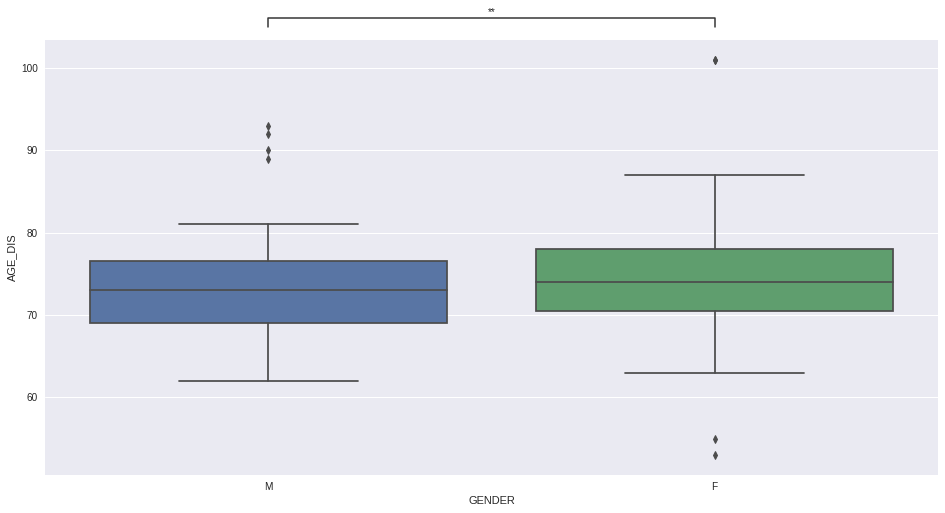

In [ ]:
import seaborn as sns

from statannotations.Annotator import Annotator

plt.figure(figsize=(16,8))

x = "GENDER"
y = "AGE_DIS"
order = ['M','F']

ax = sns.boxplot(data=data, x=x, y=y)
pairs=[('M','F')]

annotator = Annotator(ax, pairs, data=data, x=x, y=y)
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()

plt.savefig('AGE_DIS_By_Gender.pdf', dpi=500, bbox_inches='tight')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

M_50-64 vs. F_50-64: Mann-Whitney-Wilcoxon test two-sided, P_val:6.933e-01 U_stat=6.500e+00
M_65-69 vs. F_65-69: Mann-Whitney-Wilcoxon test two-sided, P_val:2.144e-01 U_stat=3.674e+03
M_70-74 vs. F_70-74: Mann-Whitney-Wilcoxon test two-sided, P_val:1.232e-04 U_stat=4.940e+03
M_75-79 vs. F_75-79: Mann-Whitney-Wilcoxon test two-sided, P_val:7.912e-03 U_stat=7.650e+03
M_>=80 vs. F_>=80: Mann-Whitney-Wilcoxon test two-sided, P_val:6.213e-01 U_stat=7.380e+02


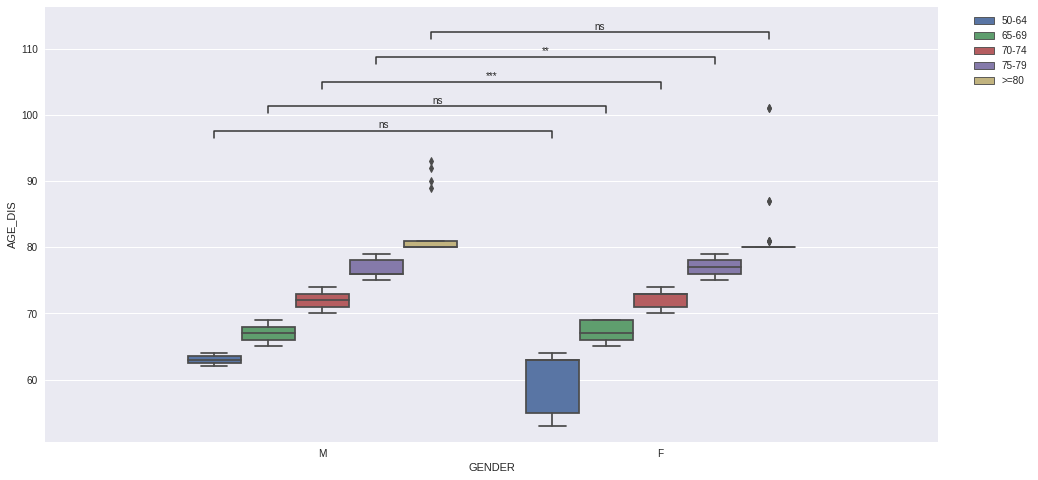

In [ ]:
plt.figure(figsize=(16,8))

x = "GENDER"
y = "AGE_DIS"
hue= "AGE"
order = ['M','F']

pairs=[
    (("M", '50-64'), ("F", '50-64')),
    (("M",'65-69'), ("F", '65-69')),
    (("M", '70-74'), ("F", '70-74')),
    (("M", '75-79'), ("F", '75-79')),
    (("M", '>=80'), ("F", '>=80')),
    ]

# In this case we just have to pass the list of categories objects to the annotate function.
age_bucket_list = data['AGE'].unique()


ax = sns.boxplot(data=data, x=x, y=y, order=order, hue=hue)
annot = Annotator(ax, pairs, data=data, x=x, y=y, order=order, hue=hue)
# annot.new_plot(ax, pairs, data=data, x=x, y=y, order=order, hue=hue)
annot.configure(test='Mann-Whitney', verbose=2)
annot.apply_test()
annot.annotate()
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.savefig('AGE_BUCKET_By_Gender.pdf', dpi=500, bbox_inches='tight')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

M_50-64 vs. F_50-64: Mann-Whitney-Wilcoxon test two-sided, P_val:6.933e-01 U_stat=6.500e+00
M_65-69 vs. F_65-69: Mann-Whitney-Wilcoxon test two-sided, P_val:2.144e-01 U_stat=3.674e+03
M_70-74 vs. F_70-74: Mann-Whitney-Wilcoxon test two-sided, P_val:1.232e-04 U_stat=4.940e+03
M_75-79 vs. F_75-79: Mann-Whitney-Wilcoxon test two-sided, P_val:7.912e-03 U_stat=7.650e+03
M_>=80 vs. F_>=80: Mann-Whitney-Wilcoxon test two-sided, P_val:6.213e-01 U_stat=7.380e+02


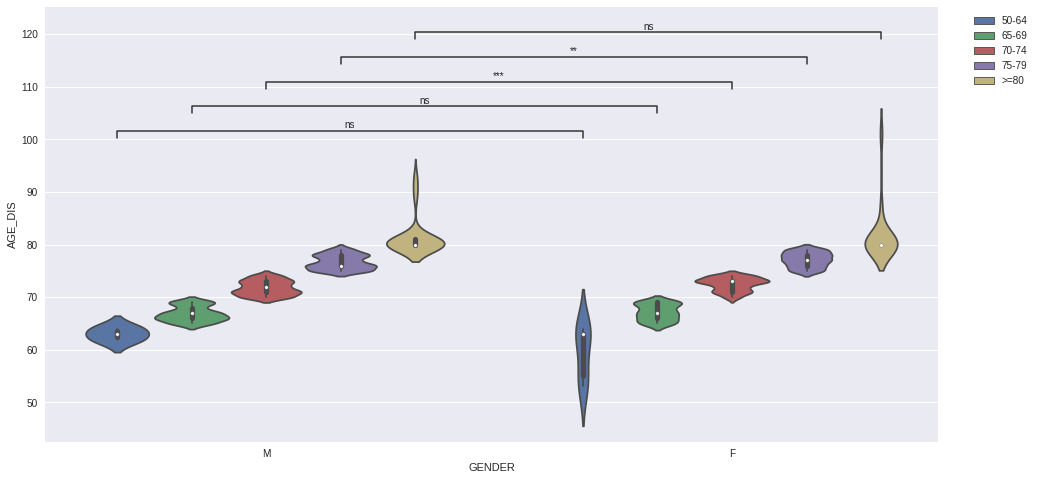

In [ ]:
plt.figure(figsize=(16,8))

x = "GENDER"
y = "AGE_DIS"
hue= "AGE"
order = ['M','F']

pairs=[
    (("M", '50-64'), ("F", '50-64')),
    (("M",'65-69'), ("F", '65-69')),
    (("M", '70-74'), ("F", '70-74')),
    (("M", '75-79'), ("F", '75-79')),
    (("M", '>=80'), ("F", '>=80')),
    ]

# In this case we just have to pass the list of categories objects to the annotate function.
age_bucket_list = data['AGE'].unique()


ax = sns.violinplot(data=data, x=x, y=y, order=order, hue=hue)
annot = Annotator(ax, pairs, data=data, x=x, y=y, order=order, plot="violinplot",hue=hue)
# annot.new_plot(ax, pairs, data=data, x=x, y=y, order=order, hue=hue)
annot.configure(test='Mann-Whitney', verbose=2)
annot.apply_test()
annot.annotate()
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.savefig('AGE_BUCKET_By_Gender_Violin.pdf', dpi=500, bbox_inches='tight')

/usr/local/lib/python3.7/dist-packages/statannotations/_Plotter.py:403: UserWarning: Implicitly setting dodge to True as it is necessary in statannotations. It must have been True for the seaborn call to yield consistent results when using `hue`.
  "Implicitly setting dodge to True as it is necessary in "


M_50-64 vs. F_50-64: Mann-Whitney-Wilcoxon test two-sided, P_val:6.933e-01 U_stat=6.500e+00
M_65-69 vs. F_65-69: Mann-Whitney-Wilcoxon test two-sided, P_val:2.144e-01 U_stat=3.674e+03
M_70-74 vs. F_70-74: Mann-Whitney-Wilcoxon test two-sided, P_val:1.232e-04 U_stat=4.940e+03
M_75-79 vs. F_75-79: Mann-Whitney-Wilcoxon test two-sided, P_val:7.912e-03 U_stat=7.650e+03
M_>=80 vs. F_>=80: Mann-Whitney-Wilcoxon test two-sided, P_val:6.213e-01 U_stat=7.380e+02


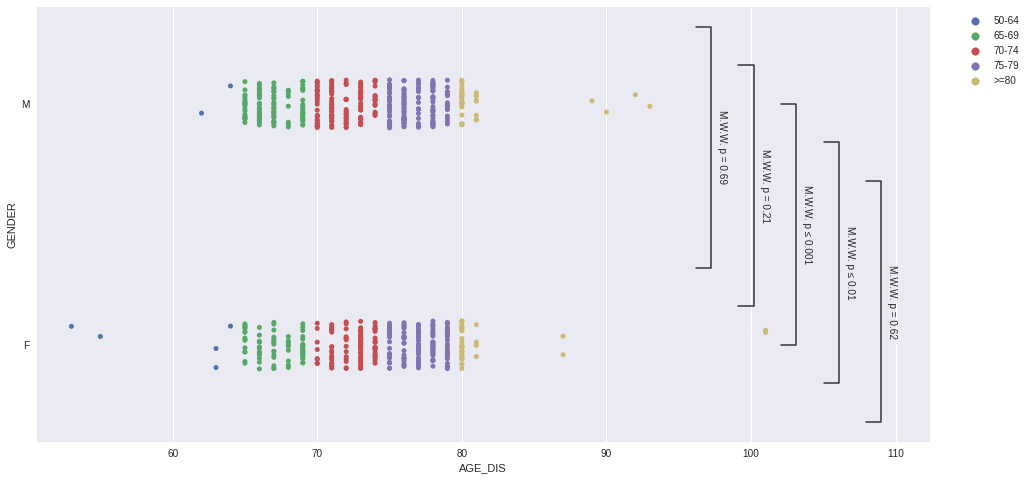

In [ ]:
plt.figure(figsize=(16,8))

y = "GENDER"
x= "AGE_DIS"
hue= "AGE"
order = ['M','F']

pairs=[
    (("M", '50-64'), ("F", '50-64')),
    (("M",'65-69'), ("F", '65-69')),
    (("M", '70-74'), ("F", '70-74')),
    (("M", '75-79'), ("F", '75-79')),
    (("M", '>=80'), ("F", '>=80')),
    ]

# In this case we just have to pass the list of categories objects to the annotate function.
age_bucket_list = data['AGE'].unique()

configuration = {'test':'Mann-Whitney',
                 'comparisons_correction':None,
                 'text_format':'star'}

ax = sns.stripplot(data=data, x=x, y=y,orient='h', order=order, hue=hue)
annot = Annotator(ax, pairs, data=data, x=x, y=y, order=order, plot='swarmplot', orient='h',hue=hue)
# annot.new_plot(ax, pairs, data=data, x=x, y=y, order=order, hue=hue)
# annot.configure(test='Mann-Whitney', verbose=2)
annot.configure(**{**configuration, "text_format":"simple", "text_offset":6})\
    .apply_test().annotate()
plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
plt.savefig('AGE_BUCKET_By_Gender_swarm.pdf', dpi=500, bbox_inches='tight')

In [ ]:
########FINISHED#######################